<a href="https://colab.research.google.com/github/jiyoungemma/User-Log-data-analytics/blob/main/ecommerce_user_log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 데이터셋 설명

- event_time : time when event happend at
- event_type : only one kind of event
   - view : a user viewed a product
   - cart : a user added a product to shopping cart
   - remove_from_cart : a user removed a product from shopping cart
   - purchase : a user purchased a product
- product_id : ID of a product
- catagory_id : product's category ID
- category_code : Product's category taxonomy (code name) if it was possible to make it. Usually present for meaningful categories and skipped for different kinds of accessories
- brand : downcased string of brand name. can be missed
- price
- user_id : permanent user ID
- user_session : 	Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause

- Multiple purchases per session
   - A session can have multiple purchase events
   - it's ok b/c it's a single order

### 라이브러리

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = mpl.font_manager.FontProperties(fname=path).get_name()
mpl.rc('font', family=font_name)
mpl.font_manager._rebuild()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import squarify # 트리맵 라이브러리
from datetime import datetime
import matplotlib as mpl
%matplotlib inline
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans


### 데이터셋 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2019-Oct.csv')

In [ ]:
df.shape

(42448764, 9)

In [ ]:
df['event_time'] = pd.to_datetime(df['event_time']).dt.tz_convert(None)

In [ ]:
df.dtypes

event_time       datetime64[ns]
event_type               object
product_id                int64
category_id               int64
category_code            object
brand                    object
price                   float64
user_id                   int64
user_session             object
dtype: object

In [ ]:
# 가격이 0인 경우 drop
zero_price = df.loc[df['price'] == 0].index
df.drop(zero_price, inplace=True)

In [ ]:
# 세션이 없는 경우는 접속 시도가 없는 경우로 인지하고 drop
df = df.dropna(subset=['user_session'])

In [ ]:
# 카테고리 코드와 브랜드 모두 결측치인 경우 drop
non_category_brand = df[(df['brand'].isnull()) & (df['category_code'].isnull())].index
df.drop(non_category_brand, inplace=True)

In [ ]:
df.isna().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    9771062
brand            2340908
price                  0
user_id                0
user_session           0
dtype: int64

In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


### 브랜드

In [ ]:
# 구매한 데이터
purchase = df.loc[df['event_type'] == 'purchase']
purchase = purchase.reset_index(drop=True)
purchase.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,2019-10-01 00:04:37,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
2,2019-10-01 00:06:02,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56
3,2019-10-01 00:07:07,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
4,2019-10-01 00:09:26,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553


In [ ]:
purchase.shape

(704461, 9)

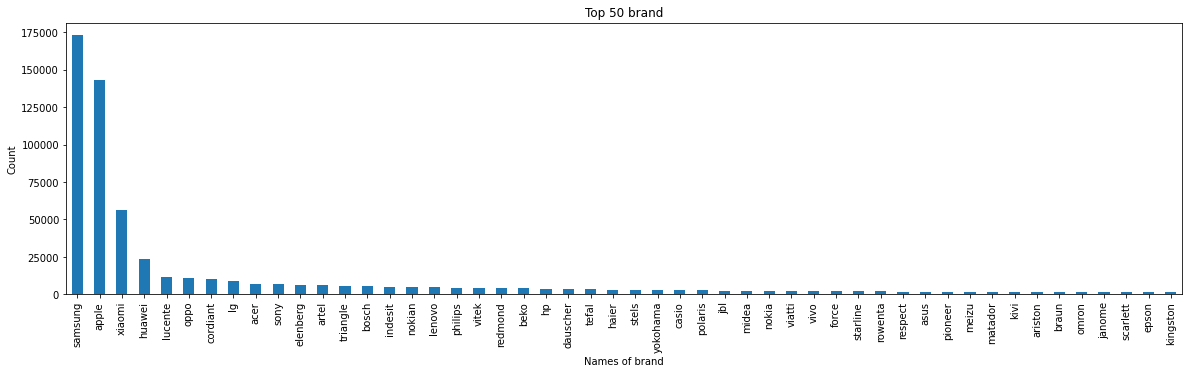

In [ ]:
# 고객이 구매한 제품의 상위 50개 브랜드
purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Top 50 brand')
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show();

In [ ]:
# 조회한 고객의 데이터
view = df.loc[df['event_type'] == 'view']
view = view.reset_index(drop=True)
view.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


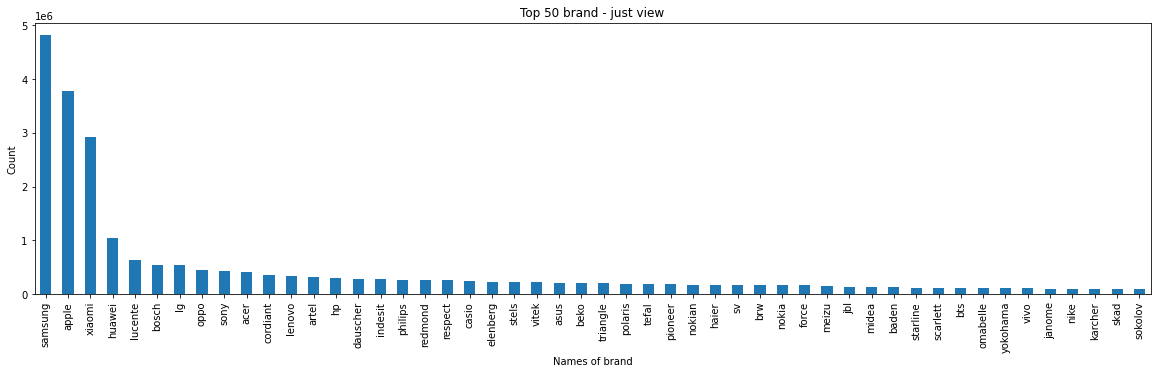

In [ ]:
# 고객이 조회한 제품의 상위 50개 브랜드
view['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Top 50 brand - just view')
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show();

### 카테고리 별

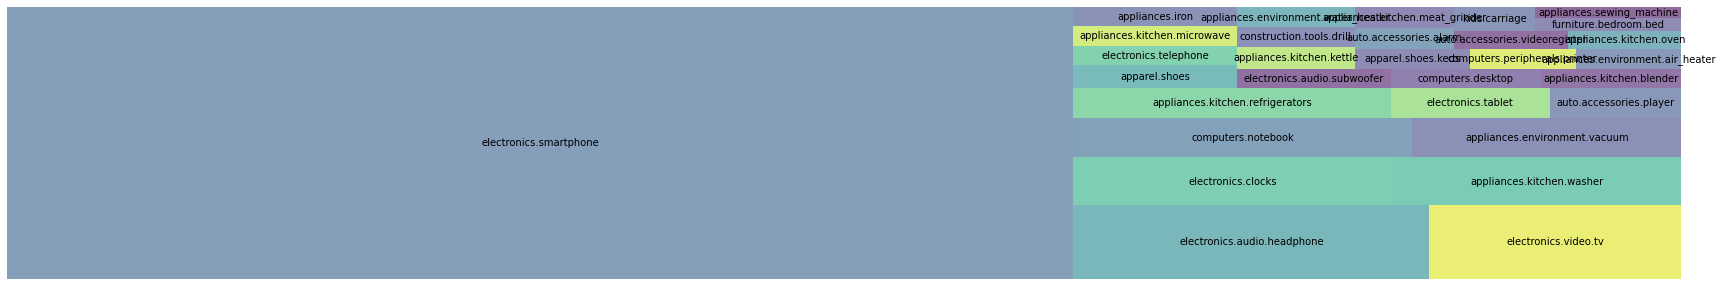

In [ ]:
# 고객이 구매한 제품의 상위 30개 카테고리
top_30 = purchase.loc[:,'category_code'].value_counts()[:30].sort_values(ascending=False)
plt.figure(figsize=(30,5))
squarify.plot(top_30, label=top_30.index.array, alpha=0.6)
plt.axis('off')
plt.show();

- 카테고리 코드의 맨 첫번째가 대분류, 마지막이 소분류를 의미

In [ ]:
# 카테고리 대분류(main category), 소분류(sub category)로 나눠서 칼럼 생성
purchase['main_category'] = purchase.category_code.str.split('.').str[0]
purchase['subcategory'] = purchase.category_code.str.split('.').str[-1]
purchase = purchase.reset_index(drop=True)
purchase.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-01 00:02:14,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564,electronics,smartphone
1,2019-10-01 00:04:37,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,electronics,smartphone
2,2019-10-01 00:06:02,purchase,5100816,2053013553375346967,NaN,xiaomi,29.51,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56,NaN,NaN
3,2019-10-01 00:07:07,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f,furniture,toilet
4,2019-10-01 00:09:26,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,electronics,headphone


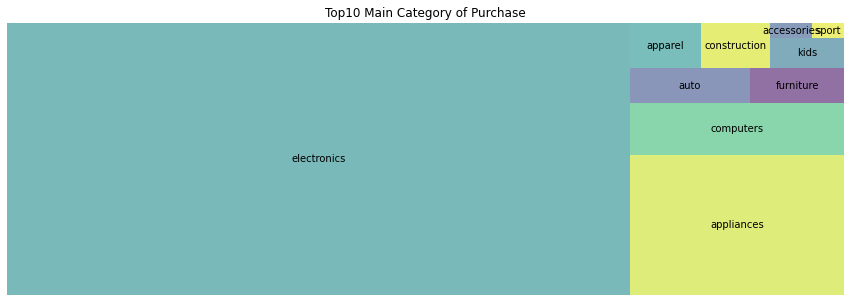

In [ ]:
# 구매한 제품 중 상위 10개 대분류
top_10_main = purchase.loc[:,'main_category'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(top_10_main, label=top_10_main.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Main Category of Purchase')
plt.show();

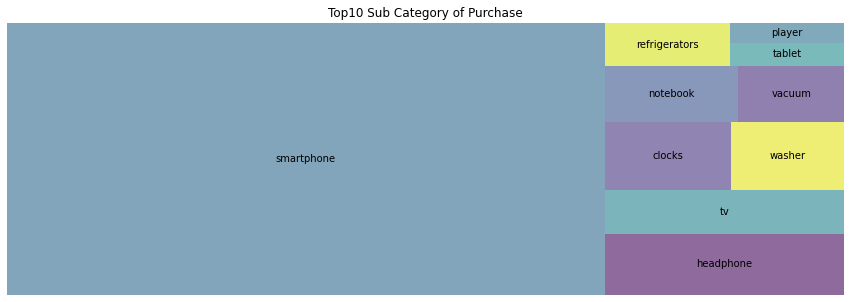

In [ ]:
# 구매한 제품 중 상위 10개 소분류
top_10_sub = purchase.loc[:,'subcategory'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(sizes=top_10_sub, label=top_10_sub.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Sub Category of Purchase')
plt.show();

In [ ]:
# electronics 에서 소분류
electronics = purchase.loc[purchase['main_category'] == 'electronics']
electronics['subcategory'].value_counts()

smartphone    338018
headphone      30503
tv             21565
clocks         17906
tablet          5603
telephone       3738
subwoofer       3348
acoustic         888
microphone       430
piano            423
video            350
photo            174
projector         82
Name: subcategory, dtype: int64

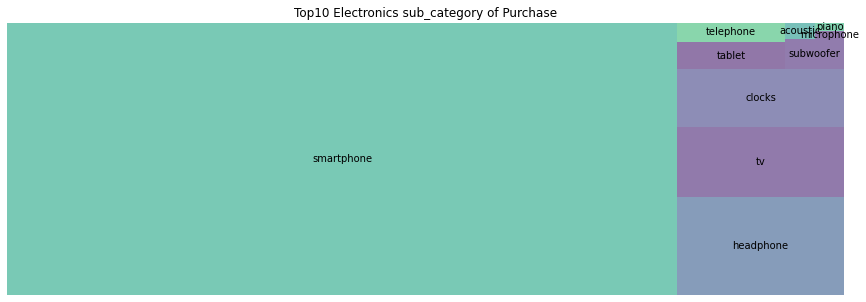

In [ ]:
# 구매 제품 중 전자제품에서 상위 10개 대분류
top_10_elec = electronics.loc[:,'subcategory'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(sizes=top_10_elec, label=top_10_elec.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Electronics sub_category of Purchase')
plt.show();

In [ ]:
# electronics 를 제외한 카테고리의 순위
non_electronics = purchase.loc[~(purchase['main_category'] == 'electronics')]
non_electronics['subcategory'].value_counts()

washer           16148
notebook         15590
vacuum           12378
refrigerators    11218
player            4647
                 ...  
skirt                4
shorts               2
jumper               2
jacket               1
soldering            1
Name: subcategory, Length: 106, dtype: int64

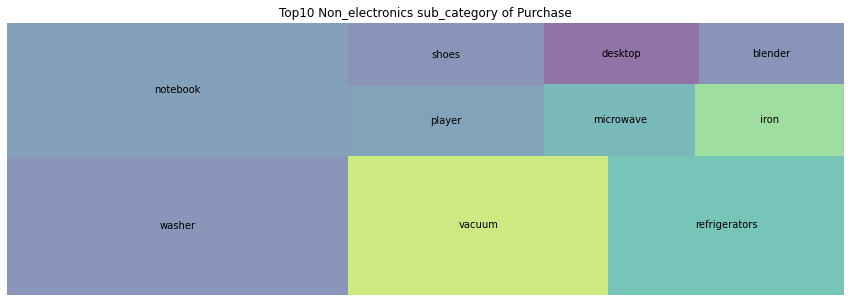

In [ ]:
# 구매 제품 중 전자제품을 제외한 제품의 상위 10개 소분류
top_10_nonelec = non_electronics.loc[:,'subcategory'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(sizes=top_10_nonelec, label=top_10_nonelec.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Non_electronics sub_category of Purchase')
plt.show();

In [ ]:
# electronics, appliances 를 제외한 카테고리의 순위
non_elec_appl = purchase.loc[(~(purchase['main_category'] == 'electronics')) & (~(purchase['main_category'] == 'appliances'))]
non_elec_appl['subcategory'].value_counts()

notebook     15590
player        4647
shoes         4255
desktop       3232
drill         2790
             ...  
skirt            4
shorts           2
jumper           2
jacket           1
soldering        1
Name: subcategory, Length: 78, dtype: int64

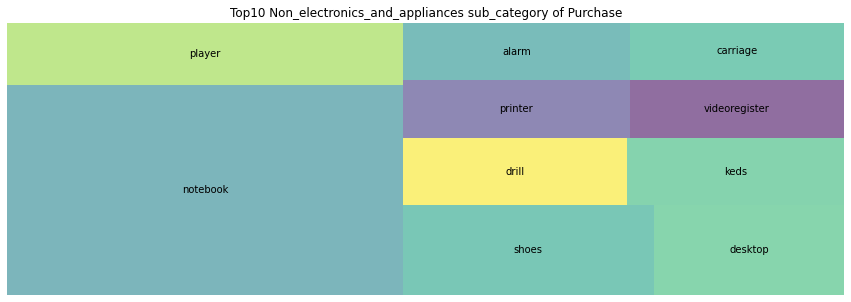

In [ ]:
# 전자제품과 가전제품을 제외하고 구매한 상품 중 상위 10개 소분류
top_10_non_elec_appl = non_elec_appl.loc[:,'subcategory'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(sizes=top_10_non_elec_appl, label=top_10_non_elec_appl.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Non_electronics_and_appliances sub_category of Purchase')
plt.show();

In [ ]:
# 카테고리 대분류(main category), 소분류(sub category)로 나눠서 칼럼 생성
view['main_category'] = view.category_code.str.split('.').str[0]
view['subcategory'] = view.category_code.str.split('.').str[-1]
view = view.reset_index(drop=True)
view.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,NaN,NaN
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances,water_heater
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,furniture,sofa
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,notebook
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,smartphone


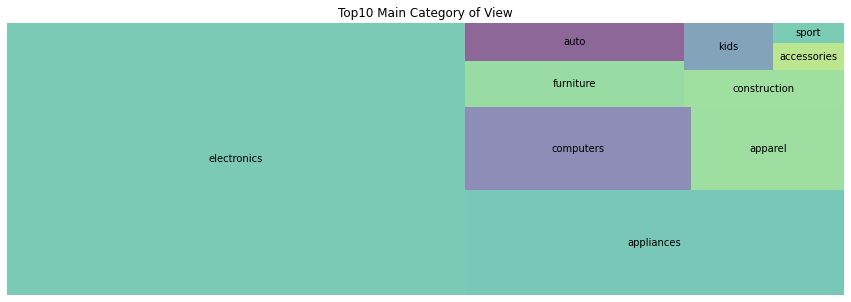

In [ ]:
# 조회한 제품 중 상위 10개의 대분류
top_10_main = view.loc[:,'main_category'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(top_10_main, label=top_10_main.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Main Category of View')
plt.show();

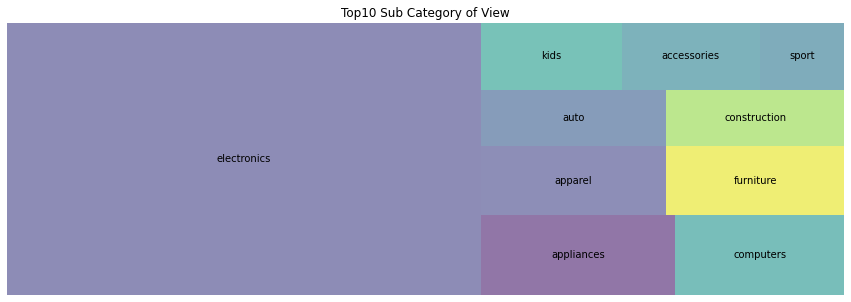

In [ ]:
# 조회한 제품 중 상위 10개의 소분류
top_10_sub = view.loc[:,'subcategory'].value_counts()[:10].sort_values(ascending=False)
plt.figure(figsize=(15,5))
squarify.plot(top_10_sub, label=top_10_main.index.array, alpha=0.6)
plt.axis('off')
plt.title('Top10 Sub Category of View')
plt.show();

### event 비율

In [ ]:
df['event_type'].value_counts()

view        37049142
cart          918987
purchase      704461
Name: event_type, dtype: int64

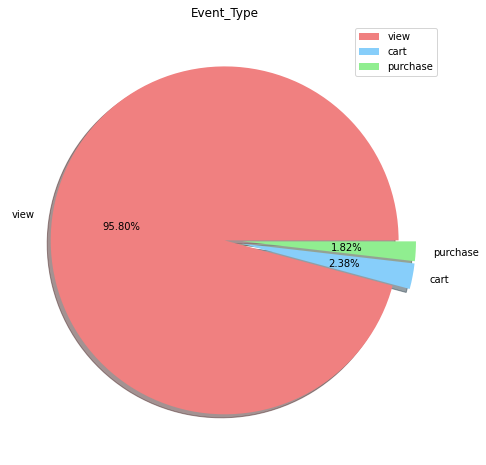

In [ ]:
# 조회, 장바구니, 구매 비율
labels = ['view','cart','purchase']
size = df['event_type'].value_counts()
plt.pie(size, colors = ['lightcoral', 'lightskyblue', 'lightgreen'], explode=[0,0.1,0.1], labels=labels, shadow=True, autopct='%.2f%%')
plt.title('Event_Type')
plt.axis('off')
plt.legend()
plt.show()

### 가격별 구매량

In [ ]:
purchase['price'].describe()

count    704461.000000
mean        318.798049
std         353.588806
min           0.880000
25%          90.170000
50%         185.820000
75%         385.850000
max        2574.070000
Name: price, dtype: float64

In [ ]:
# 평균 가격보다 높은 가격대의 제품 대분류
high_avg = purchase.loc[purchase['price'] > 318]
high_avg['main_category'].value_counts()

electronics     169446
appliances       13451
computers        12751
furniture         1659
kids               727
construction       446
auto               322
sport              258
country_yard        18
apparel              2
accessories          2
Name: main_category, dtype: int64

In [ ]:
# 중앙값보다 높은 금액의 상품 대분류
high_med = purchase.loc[purchase['price'] > 184]
high_med['main_category'].value_counts()

electronics     273587
appliances       28114
computers        19288
furniture         3074
auto              1181
construction      1098
kids              1023
sport              638
apparel            106
country_yard        34
accessories         22
Name: main_category, dtype: int64

In [ ]:
purchase.shape

(704461, 11)

In [ ]:
purchase.loc[purchase['price'] >= 318].shape

(214542, 11)

In [ ]:
(214542 / 704461) *100 # 전체 구매자 중 평균가격보다 높은 금액대의 상품을 구매한 비율

30.45477322378386

In [ ]:
high_med.shape

(353886, 11)

In [ ]:
(353886 / 704461) *100 # 전체 구매자 중 중앙값보다 높은 금액대의 상품을 구매한 비율

50.23500236350912

In [ ]:
elec = purchase.loc[purchase['main_category'] == "electronics"]

In [ ]:
elec['price'].mean() # 전자제품을 구매한 사람들의 평균 지출액

417.1453623873433

- 전자제품을 구매한 사람들의 평균 지출액이 전체 구매고객의 지출 평균보다 높아 중앙값보다 평균이 높게 나온 것으로 판단

### RFM 지수
- 가치있는 고객을 추출해내어 이를 기준으로 고객을 분류할 수 있는 지수
- segment
   - segment1 : 누적 구매횟수와 누적 구매금액이 많으면서 최근 구매이력이 있는 고객 → VVIP
   - segment2 : 누적 구매횟수는 많지만 누적 구매금액이 적고 최근 구매이력이 있는 고객 → VIP or VVIP 로 끌어 올려야하는 타겟 고객
   - segment3 : 누적 구매횟수와 구매 금액이 많지만 최근 구매이력은 없는 고객 → 변심 고객이 되돌아올 수 있도록 즉각적이고 긴급한 마케팅 대응 필요
   - segment4 : 누적 구매횟수는 적으나 최근 구매이력이 있는 고객 → 향후 VIP, VVIP로 끌어올려야 하는 타겟 고객
   - segment5 : 일정 이상 마케팅 시나리오에 반응하지 않는다면 제거 대상인 체리피커

In [ ]:
merge_session = purchase.groupby(by = 'user_session').agg(Date_order = ('event_time', lambda x: x.max()),
                                                          user_id = ('user_id', lambda x: x.unique()),
                                                          Quantity = ('user_session', 'count'),
                                                          money_spent = ('price', 'sum')).reset_index(drop=True)

In [ ]:
# 날짜마다 몇개 세션인지, 얼마 지불했는지
merge_session.head()

,Date_order,user_id,Quantity,money_spent
0,2019-10-06 11:34:30,546521725,1,289.52
1,2019-10-25 08:39:11,560486342,1,171.90
2,2019-10-17 13:37:59,560744406,2,379.78
3,2019-10-15 08:09:02,520649833,1,90.07
4,2019-10-23 14:27:08,534210306,2,571.92


In [ ]:
merge_session.dtypes

Date_order      object
user_id          int64
Quantity         int64
money_spent    float64
dtype: object

In [ ]:
import datetime
merge_session['Date_order'] = pd.to_datetime(merge_session['Date_order'])

In [ ]:
# 2019.11.1 기준 얼마나 최근에 구매했는지
import datetime as dt
import numpy as np
date = dt.datetime(2019,11,1)
merge_session['last_purchase'] = date - merge_session['Date_order']
merge_session['last_purchase'].astype('timedelta64[D]')
merge_session['last_purchase'] = merge_session['last_purchase'] / np.timedelta64(1, 'D')

In [ ]:
merge_session.head()

,Date_order,user_id,Quantity,money_spent,last_purchase
0,2019-10-06 11:34:30,546521725,1,289.52,25.517708
1,2019-10-25 08:39:11,560486342,1,171.90,6.639456
2,2019-10-17 13:37:59,560744406,2,379.78,14.431956
3,2019-10-15 08:09:02,520649833,1,90.07,16.660394
4,2019-10-23 14:27:08,534210306,2,571.92,8.397824


In [ ]:
# RFM 지수
user_pattern = merge_session.groupby('user_id').agg(Recency = ('last_purchase', lambda x: x.min()),
                                               Frequency = ('user_id', lambda x: x.count()),
                                               Monetary = ('money_spent', lambda x: x.sum()))

In [ ]:
purchase['user_id'].nunique()

333701

In [ ]:
user_pattern.sort_values(by='Monetary')

,Recency,Frequency,Monetary
user_id,,,
563893002,6.849687,1,0.88
566252844,0.130984,1,0.88
535243241,2.606574,1,0.88
534066409,6.675023,1,0.88
513085966,23.426921,1,0.88
...,...,...,...
512386086,0.587523,152,182470.80
530834332,0.778970,65,187128.93
515384420,0.324502,64,210749.77


In [ ]:
user_pattern['Recency'].describe()

count    333701.000000
mean         14.183346
std           8.673088
min           0.000509
25%           6.666169
50%          13.693900
75%          21.095602
max          30.995810
Name: Recency, dtype: float64

In [ ]:
user_pattern['Frequency'].describe()

count    333701.000000
mean          1.795820
std           2.404126
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         152.000000
Name: Frequency, dtype: float64

In [ ]:
user_pattern['Monetary'].describe()

count    333701.000000
mean        673.000058
std        2101.621661
min           0.880000
25%         111.820000
50%         249.860000
75%         613.920000
max      265569.520000
Name: Monetary, dtype: float64

In [ ]:
# 2번 이상 구매한 고객
more_twice = user_pattern.loc[user_pattern['Frequency'] >= 2]

In [ ]:
more_twice.shape

(105726, 9)

In [ ]:
(105726 / 333701) * 100 # 2번 이상 구매한 고객 비율

31.682853812245092

### 고객 분류

In [ ]:
# recency, frequency, monetary 를 사분위수로 분류
user_pattern.quantile(q=[0.25,0.5,0.75])

,Recency,Frequency,Monetary
0.25,6.666169,1.0,111.82
0.50,13.693900,1.0,249.86
0.75,21.095602,2.0,613.92


In [ ]:
quantile = user_pattern.quantile(q=[0.25,0.5,0.75]).to_dict()
quantile

{'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 2.0},
 'Monetary': {0.25: 111.82, 0.5: 249.86, 0.75: 613.92},
 'Recency': {0.25: 6.666168981481482,
  0.5: 13.693900462962963,
  0.75: 21.095601851851853}}

In [ ]:
# recency - 점수 낮을수록 좋음
def Recency(x, p, d):
  if x <= d[p][0.25]:
    return 1
  elif x <= d[p][0.50]:
    return 2
  elif x <= d[p][0.75]:
    return 3
  else:
    return 4

# frequency, monetary - 점수 낮을수록 좋음
def FM(x, p, d):
  if x <= d[p][0.25]:
    return 4
  elif x <= d[p][0.50]:
    return 3
  elif x <= d[p][0.75]:
    return 2
  else:
    return 1

In [ ]:
user_pattern['Recency_score'] = user_pattern['Recency'].apply(Recency, args = ('Recency', quantile,))
user_pattern['Frequency_score'] = user_pattern['Frequency'].apply(FM, args = ('Frequency', quantile,))
user_pattern['Monetary_score'] = user_pattern['Monetary'].apply(FM, args = ('Monetary', quantile,))
user_pattern['RFM_seg'] = user_pattern.Recency_score.map(str) + user_pattern.Frequency_score.map(str) + user_pattern.Monetary_score.map(str)
user_pattern['RFM_score'] = user_pattern.Recency_score.map(int) + user_pattern.Frequency_score.map(int) + user_pattern.Monetary_score.map(int)

In [ ]:
user_pattern.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_seg,RFM_score
user_id,,,,,,,,
264649825,25.141539,2,1240.04,4,2,1,421,7
303160429,18.440637,1,340.59,3,4,2,342,9
340041246,17.384965,3,915.52,3,1,1,311,5
384989212,13.527789,1,41.44,2,4,4,244,10
396222093,7.253611,1,48.14,2,4,4,244,10


In [ ]:
user_pattern['RFM_score'].value_counts()

9     58520
10    53288
8     44267
11    40717
7     33188
6     26142
12    22245
5     21181
4     18294
3     15859
Name: RFM_score, dtype: int64

In [ ]:
# 3~12점으로 분포되어 있어 5개 구간을 2점씩 나누어 분배
def label(data):
  if data['RFM_score'] >= 11:
    return "segment5"
  elif ((data['RFM_score'] >= 9) & (data['RFM_score'] < 11)):
    return "segment4"
  elif  ((data['RFM_score'] >= 7) & (data['RFM_score'] < 9)):
    return "segment3"
  elif ((data['RFM_score'] >= 5) & (data['RFM_score'] < 7)):
    return "segment2"
  else:
    return "segment1"

In [ ]:
user_pattern['RFM_label'] = user_pattern.apply(label, axis=1)

In [ ]:
user_pattern

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_seg,RFM_score,RFM_label
user_id,,,,,,,,,
264649825,25.141539,2,1240.04,4,2,1,421,7,segment3
303160429,18.440637,1,340.59,3,4,2,342,9,segment4
340041246,17.384965,3,915.52,3,1,1,311,5,segment2
384989212,13.527789,1,41.44,2,4,4,244,10,segment4
396222093,7.253611,1,48.14,2,4,4,244,10,segment4
...,...,...,...,...,...,...,...,...,...
566270177,0.061609,1,75.94,1,4,4,144,9,segment4
566272569,0.024861,2,254.84,1,2,2,122,5,segment2
566274637,0.037755,1,2011.63,1,4,1,141,6,segment2


In [ ]:
RFM = user_pattern.groupby("RFM_label").agg({"Recency": "mean", "Frequency" : "mean", "Monetary" : ["mean","count"]}).round(2)

In [ ]:
RFM

Recency Frequency Monetary        
             mean      mean     mean   count
RFM_label                                   
segment1     4.94      5.55  2886.06   34153
segment2    10.59      2.60  1106.17   47323
segment3    11.10      1.37   495.94   77455
segment4    15.55      1.05   263.72  111808
segment5    23.27      1.00    91.58   62962

In [ ]:
RFM["Monetary"]["count"].sum()

333701

In [ ]:
# segment1
(34153 / 333701)*100

10.234611223820126

In [ ]:
# segment2
(47323 / 333701)*100

14.181258072346203

In [ ]:
# segment3
(77455 / 333701)*100

23.210898379087865

In [ ]:
# segment4
(111808 / 333701)*100

33.5054434958241

In [ ]:
# segment5
(62962 / 333701)*100

18.8677888289217

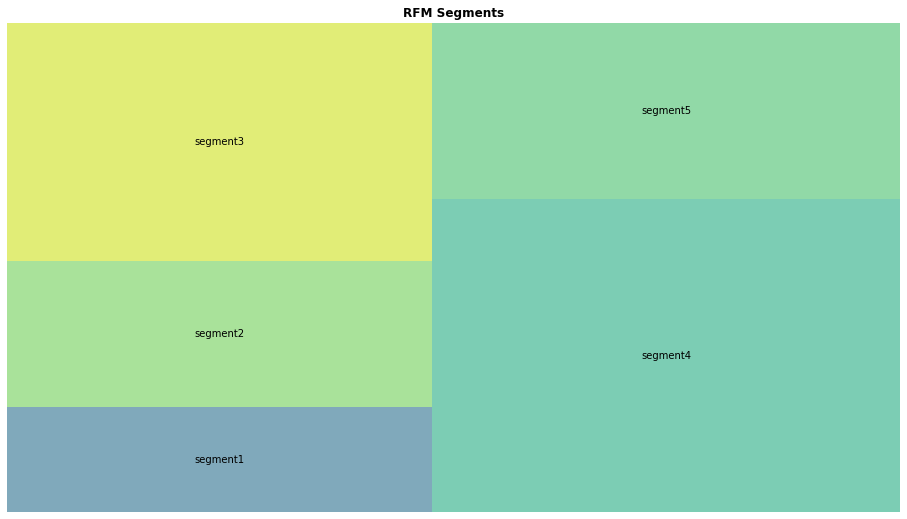

In [ ]:
# RFM.columns = RFM.columns.droplevel()
RFM.columns = ['RecencyMean', 'FrequencyMean','MonetaryMean','Count']
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16,9)
squarify.plot(sizes=RFM['Count'], label=['segment1','segment2','segment3','segment4','segment5'], alpha=.6)
plt.title("RFM Segments", fontweight='bold')
plt.axis("off")
plt.show();

### segment3, segment4에 있는 고객의 주요 상품

In [ ]:
# segment3, segment4 고객 데이터 불러오기
seg3_4 = pd.read_csv("/content/drive/MyDrive/seg3_4.csv")

In [ ]:
seg3_4.head()

,user_id,RFM_label,brand,main_category,subcategory,price
0,264649825,segment3,kiturami,NaN,NaN,552.14
1,264649825,segment3,kiturami,NaN,NaN,687.90
2,303160429,segment4,garmin,electronics,clocks,340.59
3,384989212,segment4,artel,appliances,oven,41.44
4,396222093,segment4,cordiant,NaN,NaN,48.14


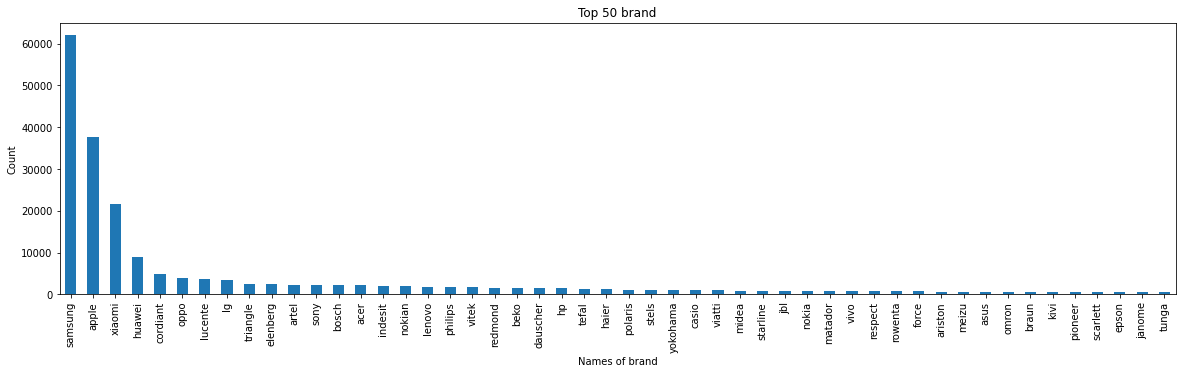

In [ ]:
# segment3, segment4 고객이 구매한 제품의 상위 50개 브랜드
seg3_4['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Top 50 brand')
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show();

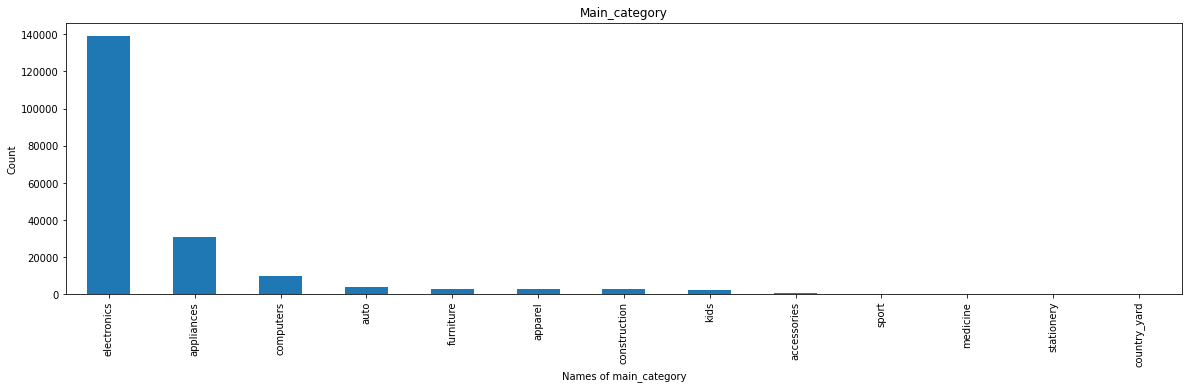

In [ ]:
# segment3, segment4 고객이 구매한 제품의 대분류
seg3_4['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Main_category')
plt.xlabel('Names of main_category')
plt.ylabel('Count')
plt.show();

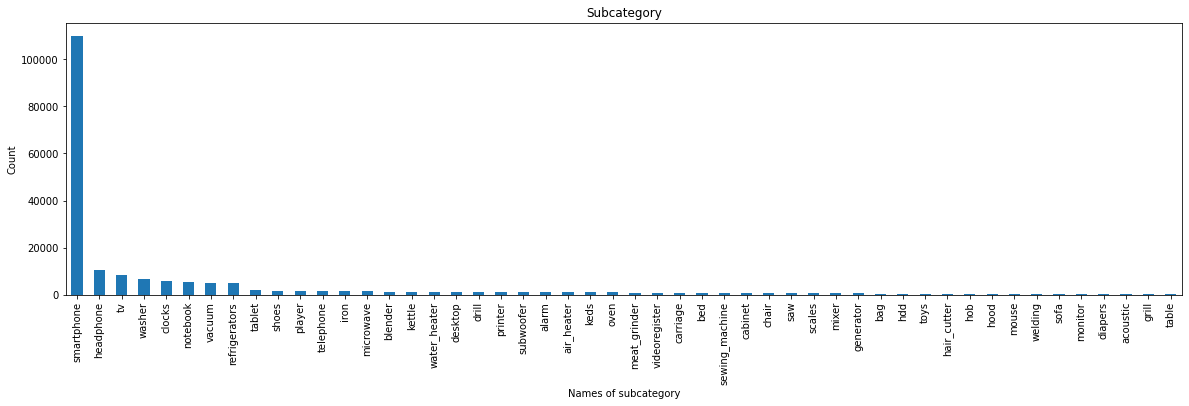

In [ ]:
# segment3, segment4 고객이 구매한 제품의 상위 50개 소분류
seg3_4['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Subcategory')
plt.xlabel('Names of subcategory')
plt.ylabel('Count')
plt.show();

### 구매하지 않은 고객
- view만하고 한번도 구매하지 않은 고객

In [ ]:
# 구매하지 않은 고객 데이터 불러오기
non_purchase = pd.read_csv("/content/drive/MyDrive/non_purchase.csv")

In [ ]:
# 대분류, 소분류 나눠 칼럼 생성
non_purchase['main_category'] = non_purchase.category_code.str.split('.').str[0]
non_purchase['subcategory'] = non_purchase.category_code.str.split('.').str[-1]
non_purchase = non_purchase.reset_index(drop=True)
non_purchase.head()

,event_time,product_id,category_code,brand,price,user_id,user_session,main_category,subcategory
0,2019-10-23 20:04:08 UTC,7002639,kids.carriage,bumbleride,769.65,33869381,d83dc524-8a2c-4780-bbe0-f8aee03b54df,kids,carriage
1,2019-10-04 17:44:37 UTC,6902133,furniture.living_room.chair,joie,143.89,184265397,2c5d0468-32e1-42f7-9b4e-b17c1d387247,furniture,chair
2,2019-10-04 17:45:18 UTC,6902133,furniture.living_room.chair,joie,143.89,184265397,2c5d0468-32e1-42f7-9b4e-b17c1d387247,furniture,chair
3,2019-10-04 17:50:50 UTC,6902303,furniture.living_room.chair,joie,111.46,184265397,2c5d0468-32e1-42f7-9b4e-b17c1d387247,furniture,chair
4,2019-10-04 17:51:04 UTC,6902303,furniture.living_room.chair,joie,111.46,184265397,2c5d0468-32e1-42f7-9b4e-b17c1d387247,furniture,chair


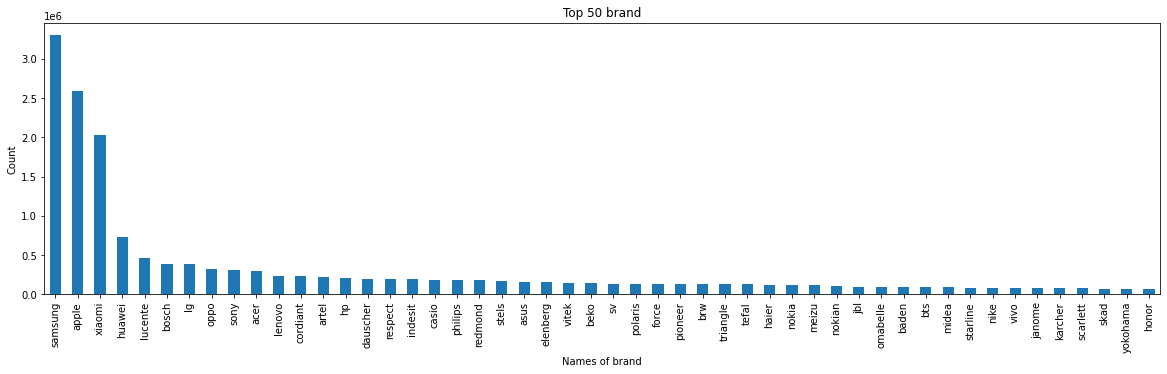

In [ ]:
# 구매하지 않은 고객이 조회한 제품 중 상위 50개 브랜드
non_purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Top 50 brand')
plt.xlabel('Names of brand')
plt.ylabel('Count')
plt.show();

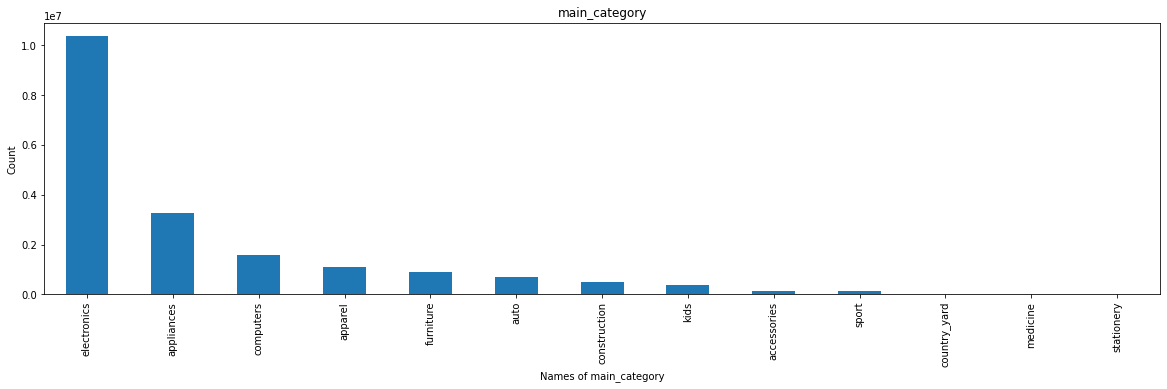

In [ ]:
# 구매하지 않은 고객이 조회한 제품의 대분류
non_purchase['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('main_category')
plt.xlabel('Names of main_category')
plt.ylabel('Count')
plt.show();

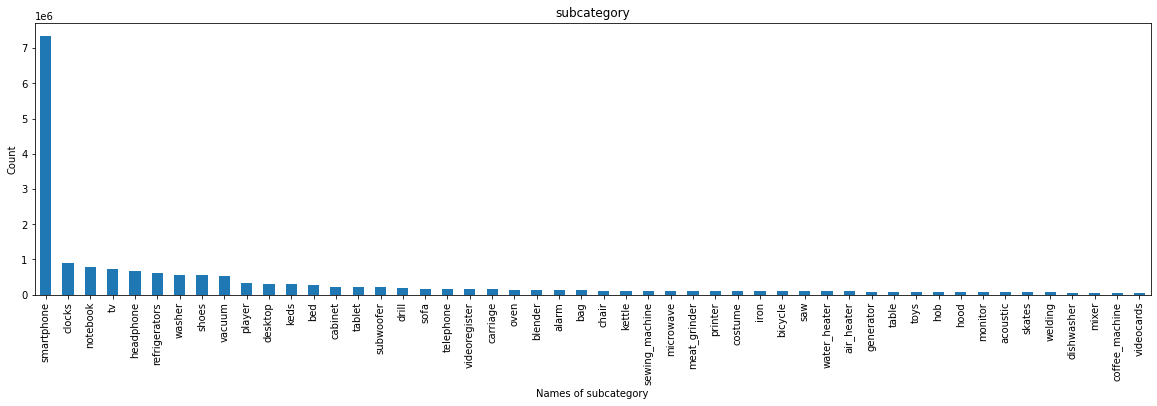

In [ ]:
# 구매하지 않은 고객이 조회한 제품 중 상위 50개 소분류
non_purchase['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('subcategory')
plt.xlabel('Names of subcategory')
plt.ylabel('Count')
plt.show();

### 매출액

In [ ]:
# 구매 제품 가격의 총 합계
purchase['price'].sum()

224580792.34

In [ ]:
elec = purchase.loc[purchase['main_category'] == "electronics"]

In [ ]:
# 구매 전자제품 가격의 총 합계
elec['price'].sum()

176464168.35999998

In [ ]:
(176464168.35999998 / 224580792.34) * 100 # 전체 매출에서 전자제품이 차지하는 비중

78.57491574472908

In [ ]:
appli = purchase.loc[purchase['main_category'] == "appliances"]

In [ ]:
# 구매 가전제품 가격의 총 합계
appli['price'].sum()

13583121.92

In [ ]:
(13583121.92 / 224580792.34) * 100 # 전체 매출에서 가전제품이 차지하는 비중

6.048211772018366

### Action plan → 충성고객에서 변심고객으로 변하는 이유
- 변심고객(segment3)의 조회와 구매기록 비교

In [19]:
# segment3 고객의 데이터 불러오기
seg3_customer = pd.read_csv("/content/drive/MyDrive/seg3_customer.csv")

In [ ]:
seg3_customer.head()

,v_user,v_time,event_type,v_product,v_brand,v_category,v_main,v_sub,v_price,p_user,p_time,event_type.1,p_product,p_brand,category_code,main_category,subcategory,p_price
0,547028884,2019-10-01 00:00:37,view,1701111,acer,computers.peripherals.monitor,computers,monitor,514.79,547028884,2019-10-01 03:42:52,purchase,1701302,samsung,computers.peripherals.monitor,computers,monitor,427.01
1,547028884,2019-10-01 00:00:37,view,1701111,acer,computers.peripherals.monitor,computers,monitor,514.79,547028884,2019-10-01 03:44:26,purchase,1701302,samsung,computers.peripherals.monitor,computers,monitor,427.01
2,547028884,2019-10-01 00:00:37,view,1701111,acer,computers.peripherals.monitor,computers,monitor,514.79,547028884,2019-10-01 03:47:15,purchase,1701302,samsung,computers.peripherals.monitor,computers,monitor,427.01
3,547028884,2019-10-01 00:00:37,view,1701111,acer,computers.peripherals.monitor,computers,monitor,514.79,547028884,2019-10-01 04:00:17,purchase,1701331,aoc,computers.peripherals.monitor,computers,monitor,385.85
4,547028884,2019-10-01 00:00:37,view,1701111,acer,computers.peripherals.monitor,computers,monitor,514.79,547028884,2019-10-01 04:07:31,purchase,1701303,samsung,computers.peripherals.monitor,computers,monitor,333.83


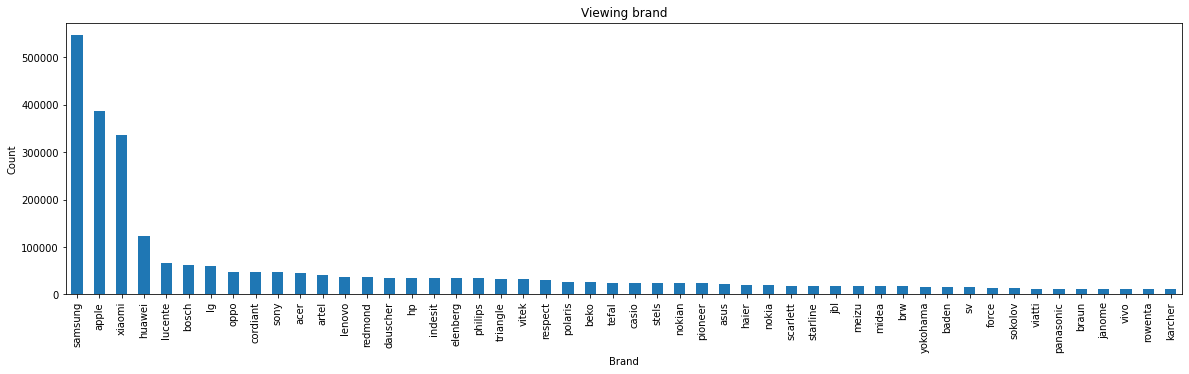

In [ ]:
# 변심고객이 조회한 제품의 상위 50개 브랜드
seg3_customer['v_brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Viewing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

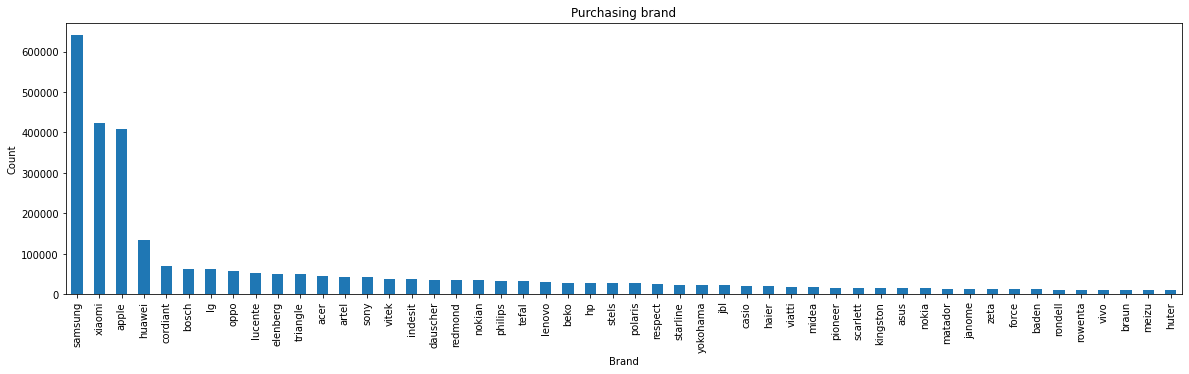

In [ ]:
# 변심고객이 구매한 제품의 상위 50개 브랜드
seg3_customer['p_brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Purchasing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

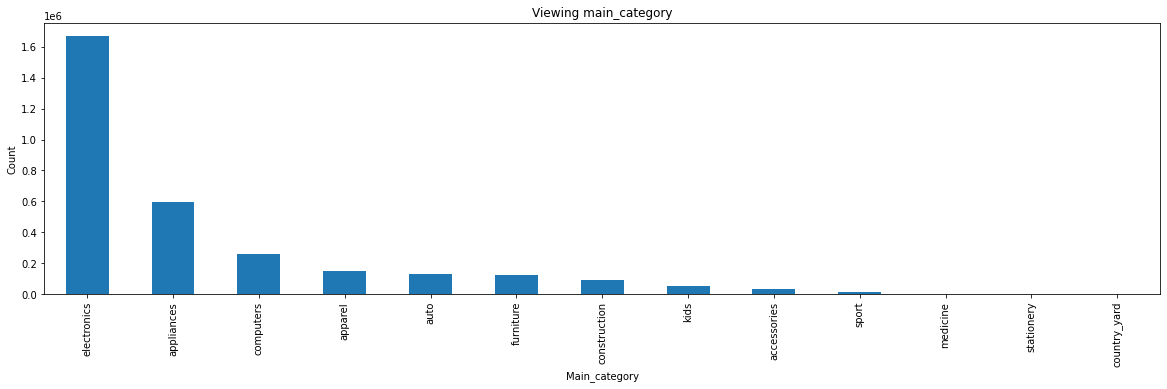

In [ ]:
# 변심고객이 조회한 제품의 대분류
seg3_customer['v_main'].value_counts().plot.bar(figsize=(20,5))
plt.title('Viewing main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

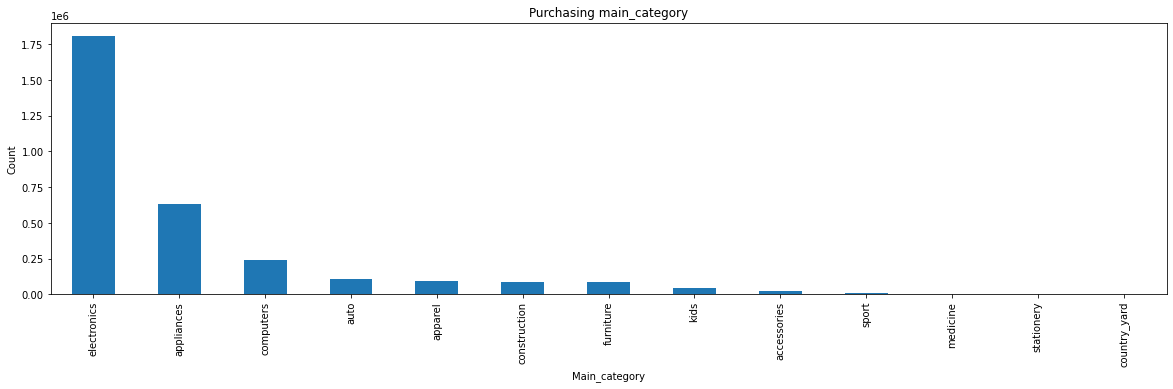

In [ ]:
# 변심고객이 구매한 제품의 대분류
seg3_customer['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Purchasing main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

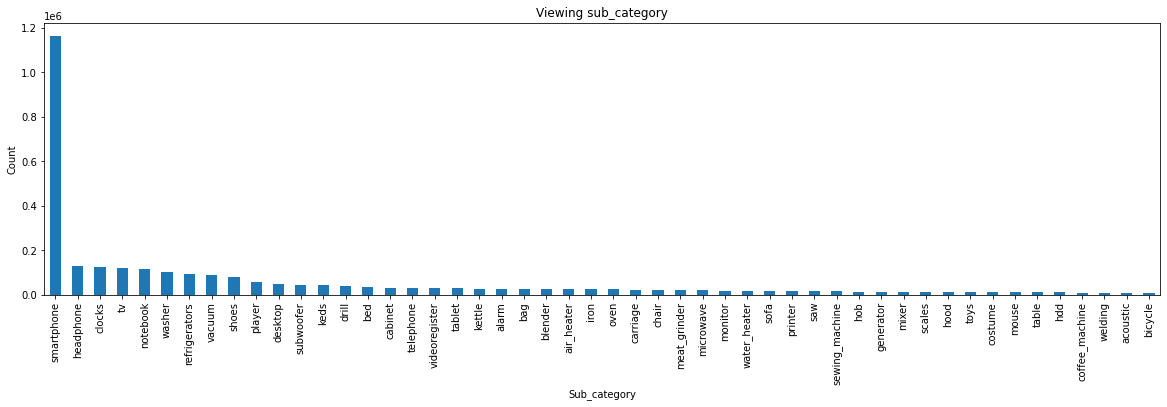

In [ ]:
# 변심고객이 조회한 상품 중 상위 50개 소분류
seg3_customer['v_sub'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Viewing sub_category')
plt.xlabel('Sub_category')
plt.ylabel('Count')
plt.show();

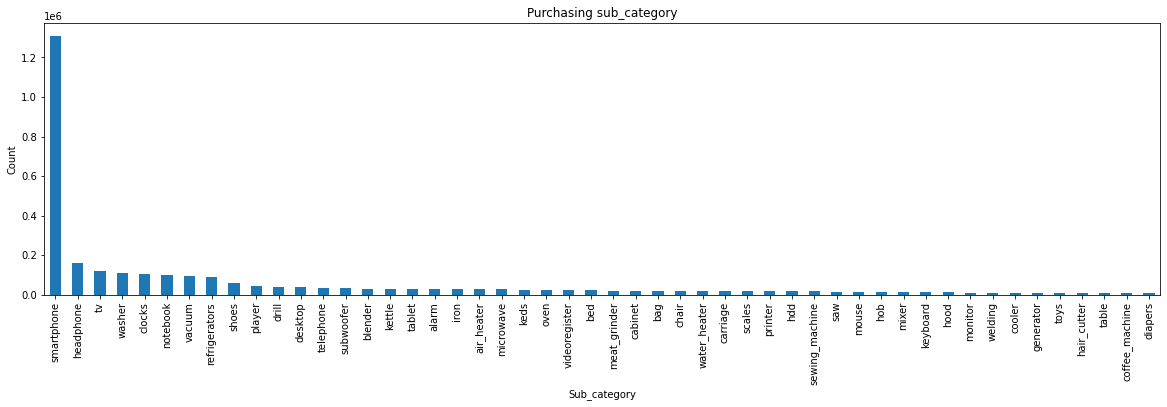

In [ ]:
# 변심고객이 구매한 제품 중 상위 50개 소분류
seg3_customer['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Purchasing sub_category')
plt.xlabel('Sub_category')
plt.ylabel('Count')
plt.show();

- 선호 카테고리에는 조회와 구매의 차이는 크게 없음

In [21]:
# 변심고객이 조회한 제품의 평균 가격
seg3view_mean = seg3_customer['v_price'].mean()
seg3view_mean

258.6865774196666

In [22]:
# 변심고객이 조회한 제품 가격의 중앙값
seg3view_med = seg3_customer['v_price'].median()
seg3view_med

142.86

In [23]:
# 변심고객이 구매한 제품의 평균 가격
seg3purchase_mean = seg3_customer['p_price'].mean()
seg3purchase_mean

227.05771559649355

In [24]:
# 변심고객이 구매한 제품 가격의 중앙값
seg3purchase_med = seg3_customer['p_price'].median()
seg3purchase_med

135.01

In [ ]:
data = [["view", 258.686577, 142.86],
        ['purchase', 227.057716, 135.01]]

In [ ]:
view_purchase = pd.DataFrame(data, columns=['data','mean','median'])

In [ ]:
# 변심고객의 조회, 구매 평균 및 중앙 가격에 대한 데이터프레임
view_purchase

,data,mean,median
0,view,258.686577,142.86
1,purchase,227.057716,135.01


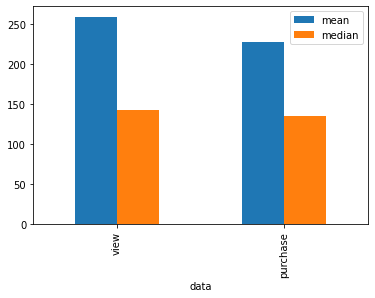

In [ ]:
view_purchase.plot.bar(x='data', y=['mean','median'])
plt.show();

- 가격 측면에서 조회와 구매의 차이가 존재
- 조회한 상품의 평균, 중앙값이 구매 상품의 것보다 높은 것을 확인

#### 다른 고객군에서도 조회제품이 구매제품보다 가격이 높게 나타날까?

In [ ]:
without_viewing = pd.read_csv("/content/drive/MyDrive/RFM_without_view.csv")
viewing = pd.read_csv("/content/drive/MyDrive/RFM_viewing.csv")

In [ ]:
without_viewing.drop(columns=['field1', 'product_id', 'category_id', 'user_session', 'user_id.1', 'Recency', 'Frequency',
       'Monetary', 'Recency_score', 'Frequency_score', 'Monetary_score', 'RFM_seg', 'RFM_score'], inplace=True)

In [ ]:
without_viewing.head()

,event_time,event_type,category_code,brand,price,user_id,main_category,subcategory,RFM_label
0,2019-10-01 00:02:14,purchase,electronics.smartphone,samsung,130.76,543272936,electronics,smartphone,segment1
1,2019-10-01 00:04:37,purchase,electronics.smartphone,apple,642.69,551377651,electronics,smartphone,segment1
2,2019-10-01 00:06:02,purchase,NaN,xiaomi,29.51,514591159,NaN,NaN,segment5
3,2019-10-01 00:07:07,purchase,furniture.bathroom.toilet,santeri,54.42,555332717,furniture,toilet,segment2
4,2019-10-01 00:09:26,purchase,electronics.audio.headphone,apple,189.91,524601178,electronics,headphone,segment5


In [ ]:
viewing.drop(columns=['user_id.1', 'Recency', 'Frequency','Monetary', 'Recency_score', 'Frequency_score', 'Monetary_score', 'RFM_seg', 'RFM_score'], inplace=True)

In [ ]:
viewing.head()

,event_time,category_code,brand,price,user_id,main_category,subcategory,RFM_label
0,2019-10-01 00:00:00,NaN,shiseido,35.79,541312140,NaN,NaN,segment5
1,2019-10-01 00:00:05,computers.desktop,pulser,908.62,512742880,computers,desktop,segment4
2,2019-10-01 00:00:15,NaN,shiseido,35.79,541312140,NaN,NaN,segment5
3,2019-10-01 00:00:22,computers.desktop,pulser,921.49,512742880,computers,desktop,segment4
4,2019-10-01 00:00:23,electronics.smartphone,xiaomi,197.55,519530528,electronics,smartphone,segment5


In [ ]:
# 조회에 대한 데이터에서 고객군 분리
seg1_view = viewing.loc[viewing['RFM_label'] == 'segment1']
seg2_view = viewing.loc[viewing['RFM_label'] == 'segment2']
seg4_view = viewing.loc[viewing['RFM_label'] == 'segment4']
seg5_view = viewing.loc[viewing['RFM_label'] == 'segment5']

In [ ]:
# 구매에 대한 데이터에서 고객군 분리
seg1_purchase = without_viewing.loc[(without_viewing['RFM_label'] == 'segment1') & (without_viewing['event_type'] == 'purchase')]
seg2_purchase = without_viewing.loc[(without_viewing['RFM_label'] == 'segment2') & (without_viewing['event_type'] == 'purchase')]
seg4_purchase = without_viewing.loc[(without_viewing['RFM_label'] == 'segment4') & (without_viewing['event_type'] == 'purchase')]
seg5_purchase = without_viewing.loc[(without_viewing['RFM_label'] == 'segment5') & (without_viewing['event_type'] == 'purchase')]

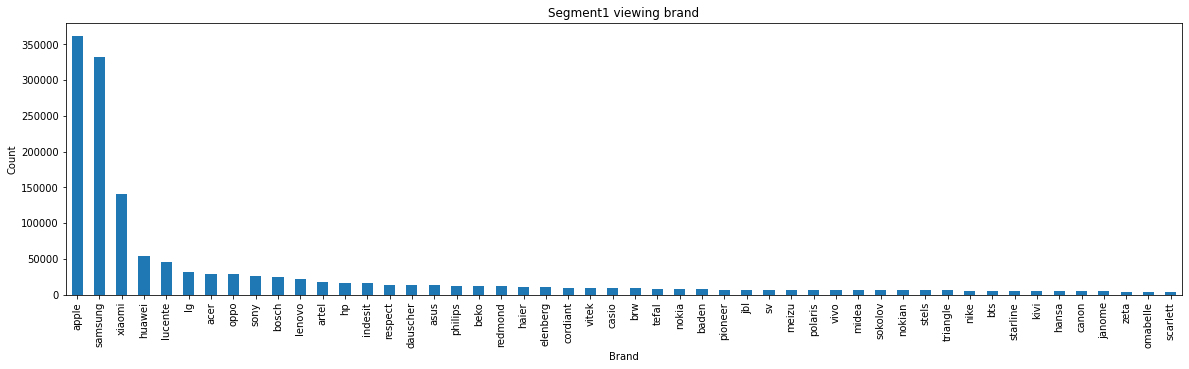

In [ ]:
# segment1 고객이 조회한 제품의 상위 50개 브랜드
seg1_view['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment1 viewing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

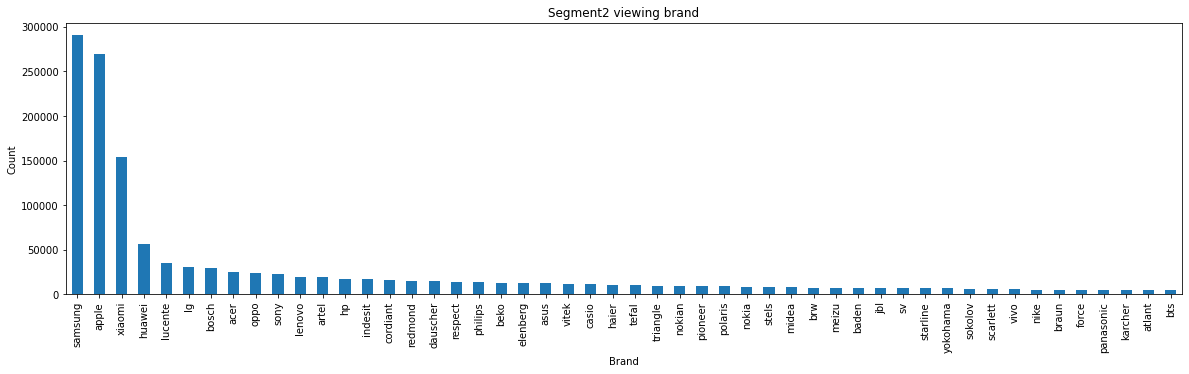

In [ ]:
# segment2 고객이 조회한 제품의 상위 50개 브랜드
seg2_view['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment2 viewing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

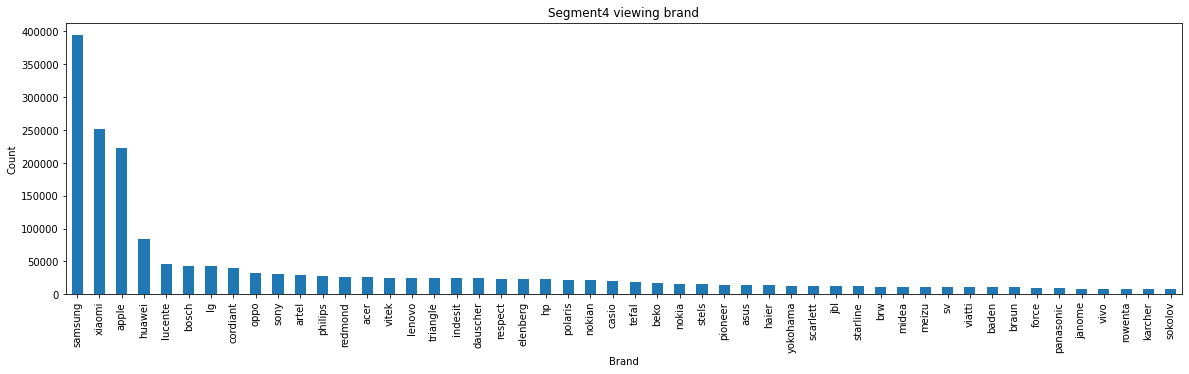

In [ ]:
# segment4 고객이 조회한 제품의 상위 50개 브랜드
seg4_view['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment4 viewing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

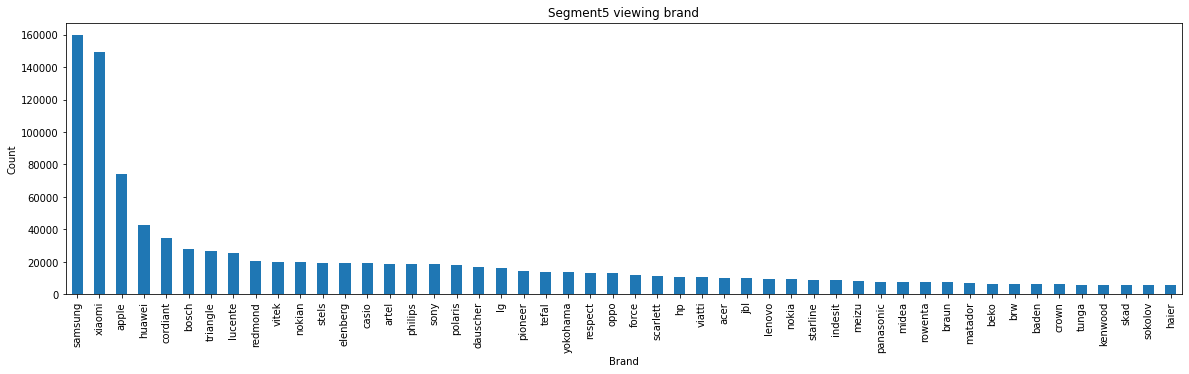

In [ ]:
# segment5 고객이 조회한 제품의 상위 50개 브랜드
seg5_view['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment5 viewing brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

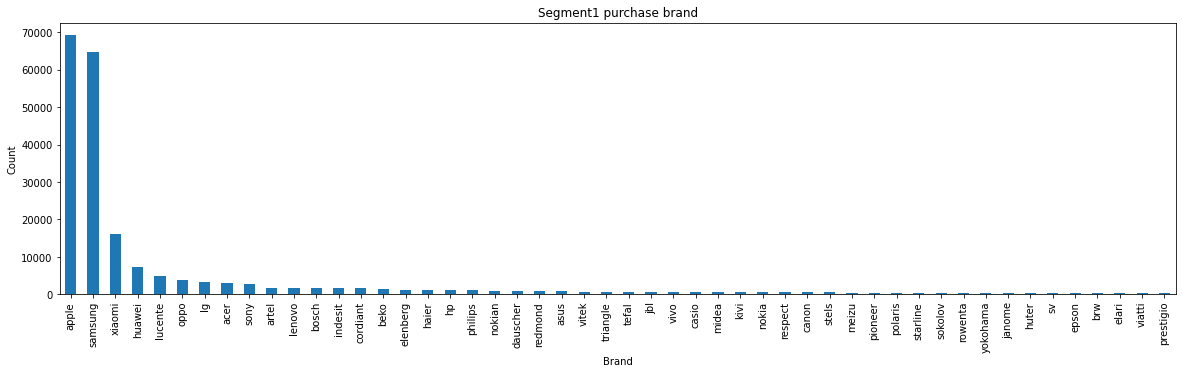

In [ ]:
# segment1 고객이 구매한 제품의 상위 50개 브랜드
seg1_purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment1 purchase brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

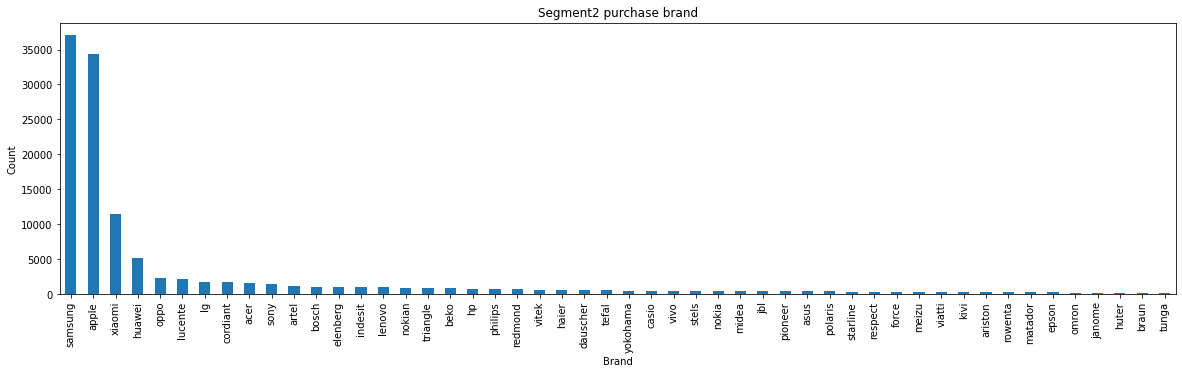

In [ ]:
# segment2 고객이 구매한 제품의 상위 50개 브랜드
seg2_purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment2 purchase brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

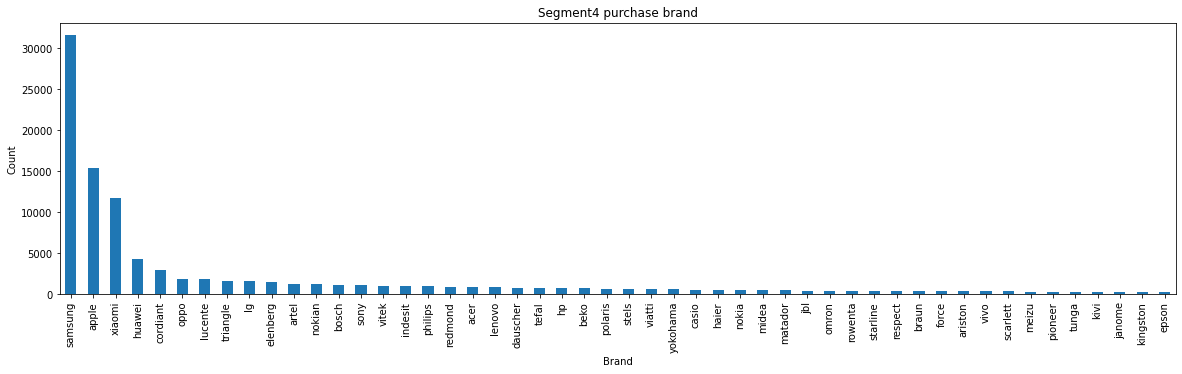

In [ ]:
# segment4 고객이 구매한 제품의 상위 50개 브랜드
seg4_purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment4 purchase brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

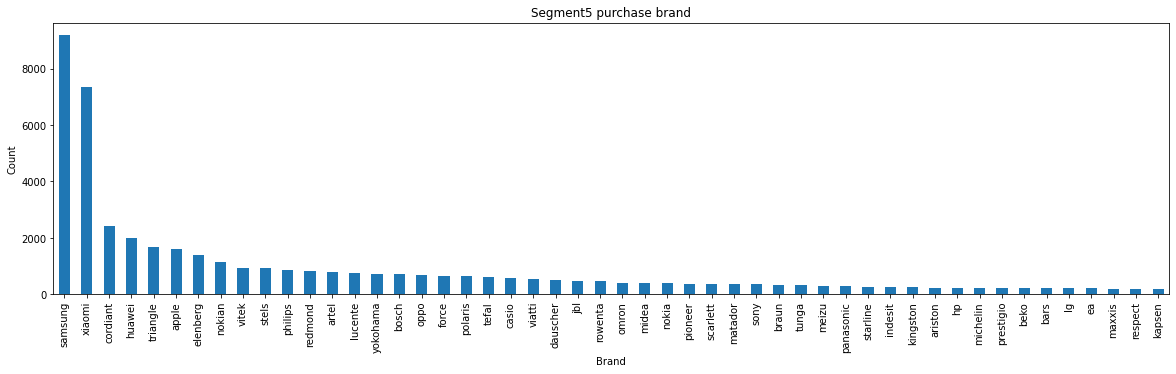

In [ ]:
# segment5 고객이 구매한 제품의 상위 50개 브랜드
seg5_purchase['brand'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment5 purchase brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show();

- segment1 view : 애플 → 삼성 → 샤오미 → 화웨이
- segment1 purchase : 애플 → 삼성 → 샤오미 →화웨이
---
- segment2 view : 삼성 → 애플 →샤오미 →화웨이
- segment2 purchase : 삼성 → 애플 → 샤오미 → 화웨이
---
- segment4 view : 삼성 → 샤오미 → 애플 → 화웨이
- segment4 purchase : 삼성 → 애플 → 샤오미 → 화웨이
---
- segment5 view : 삼성 → 샤오미 → 애플 → 화웨이
- segment5 purchase : 삼성 → 샤오미 → 코디언트 → 화웨이

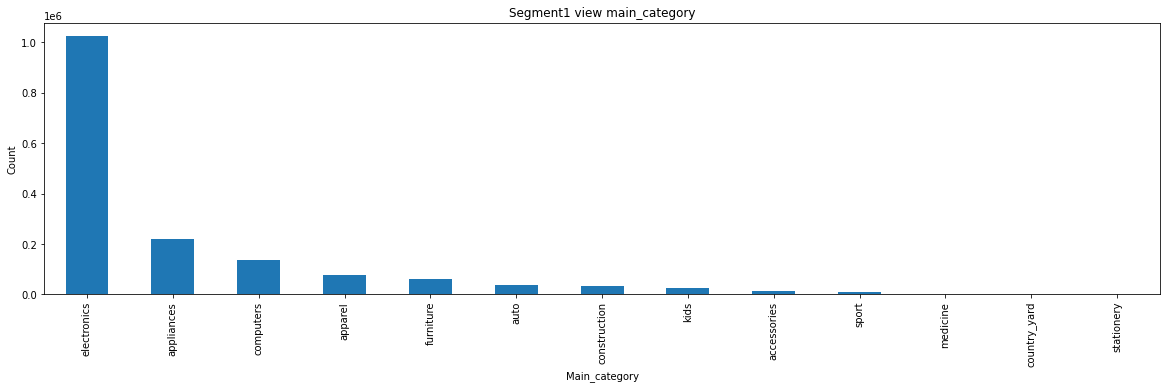

In [ ]:
# segment1 고객이 조회한 제품의 대분류
seg1_view['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment1 view main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

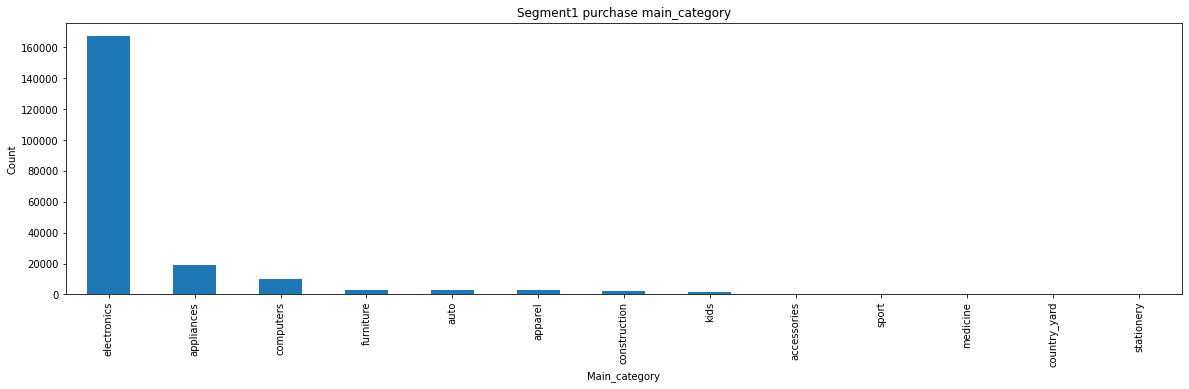

In [ ]:
# segment1 고객이 구매한 제품의 대분류
seg1_purchase['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment1 purchase main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

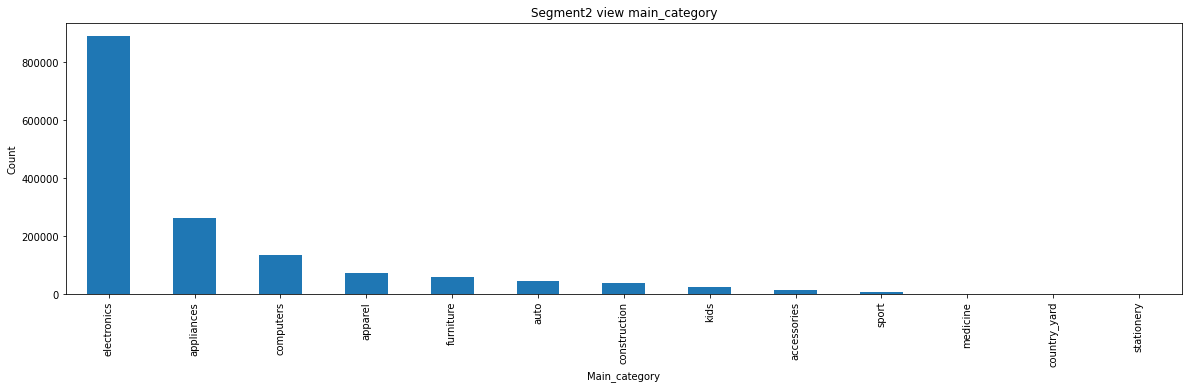

In [ ]:
# segment2 고객이 조회한 제품의 대분류
seg2_view['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment2 view main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

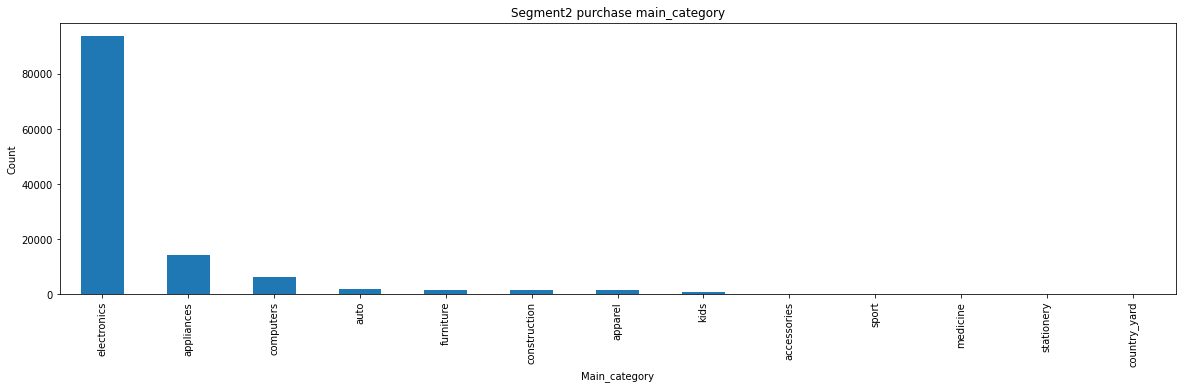

In [ ]:
# segment2 고객이 구매한 제품의 대분류
seg2_purchase['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment2 purchase main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

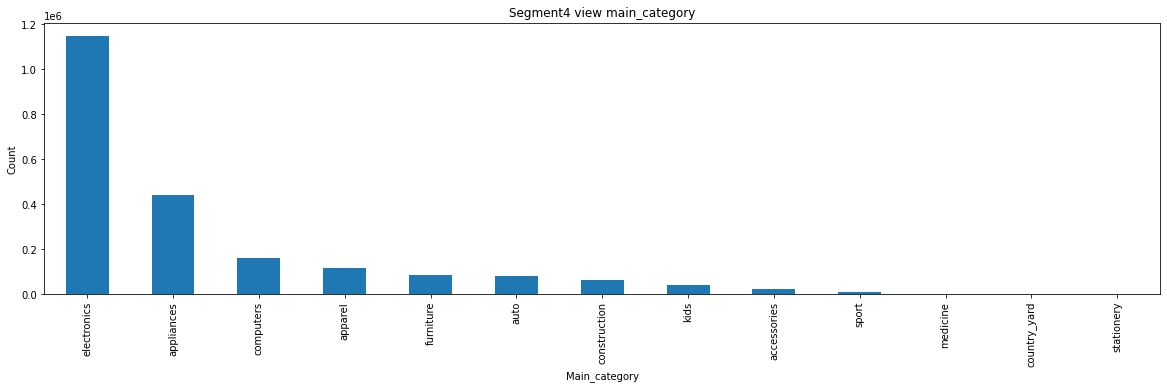

In [ ]:
# segment4 고객이 조회한 제품의 대분류
seg4_view['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment4 view main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

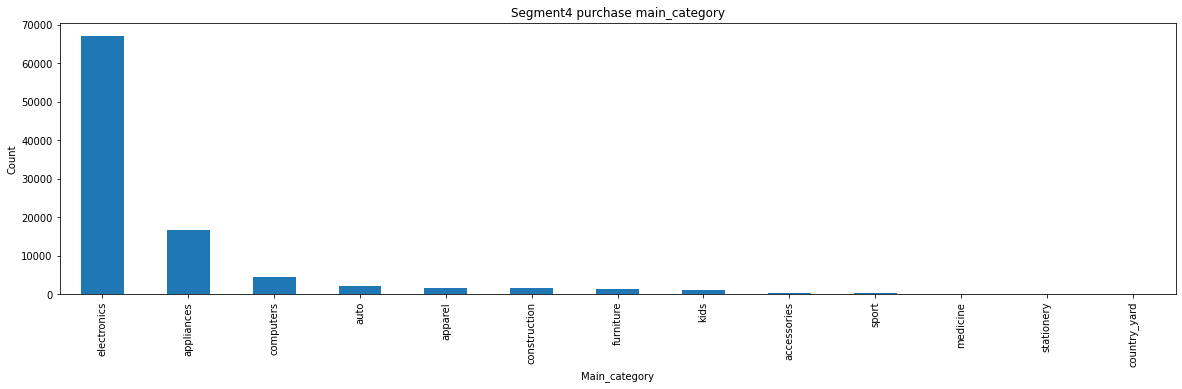

In [ ]:
# segment4 고객이 구매한 제품의 대분류
seg4_purchase['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment4 purchase main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

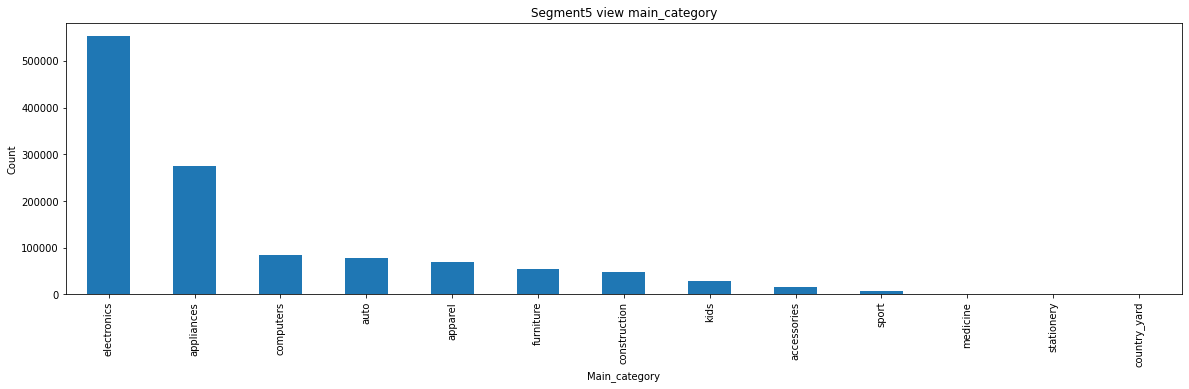

In [ ]:
# segment5 고객이 조회한 제품의 대분류
seg5_view['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment5 view main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

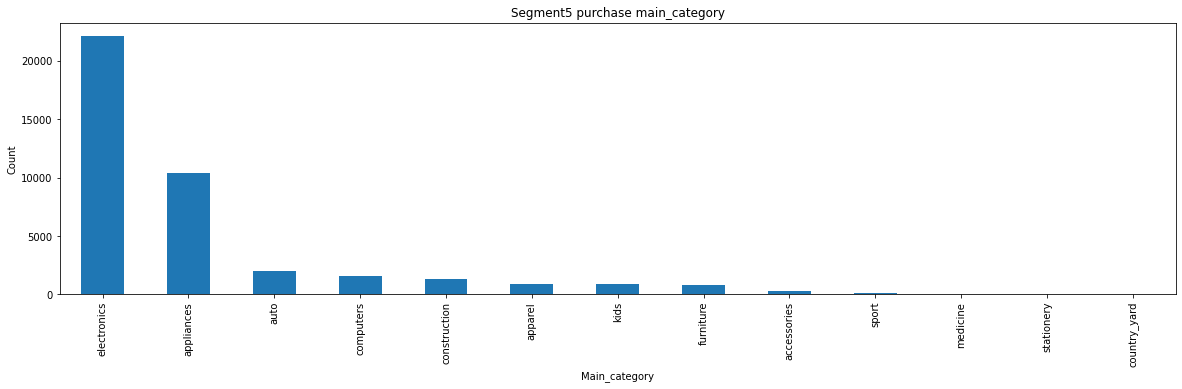

In [ ]:
# segment5 고객이 구매한 제품의 대분류
seg5_purchase['main_category'].value_counts().plot.bar(figsize=(20,5))
plt.title('Segment5 purchase main_category')
plt.xlabel('Main_category')
plt.ylabel('Count')
plt.show();

- segment5 를 제외한 다른 고객군에서는 모두 동일하게 electronics → appliances → computers 가 상위에 위치
- segment5의 경우 조회제품군의 대분류에서는 다른 고객군과 일치하지만 구매제품군에서는 electronics → appliancs → auto → computers 가 상위에 위치 

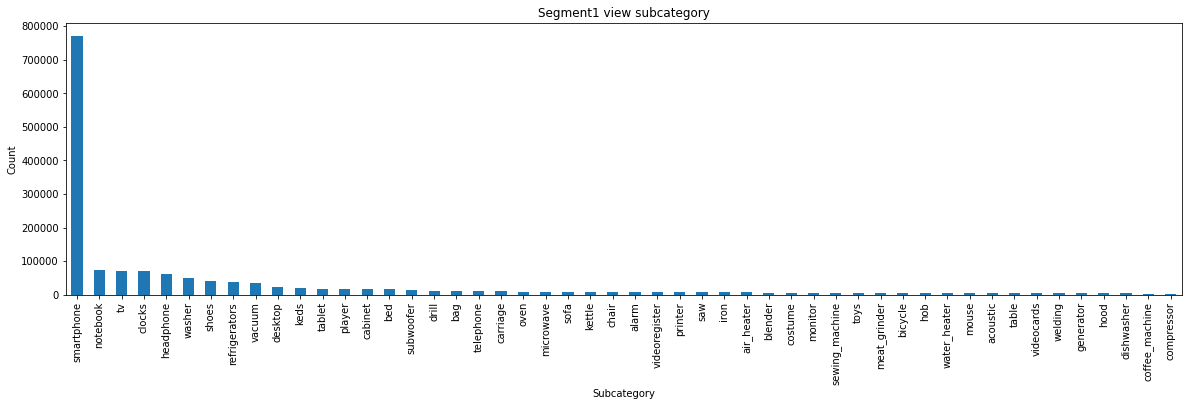

In [ ]:
# segment1 고객이 조회한 제품의 상위50개 소분류
seg1_view['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment1 view subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

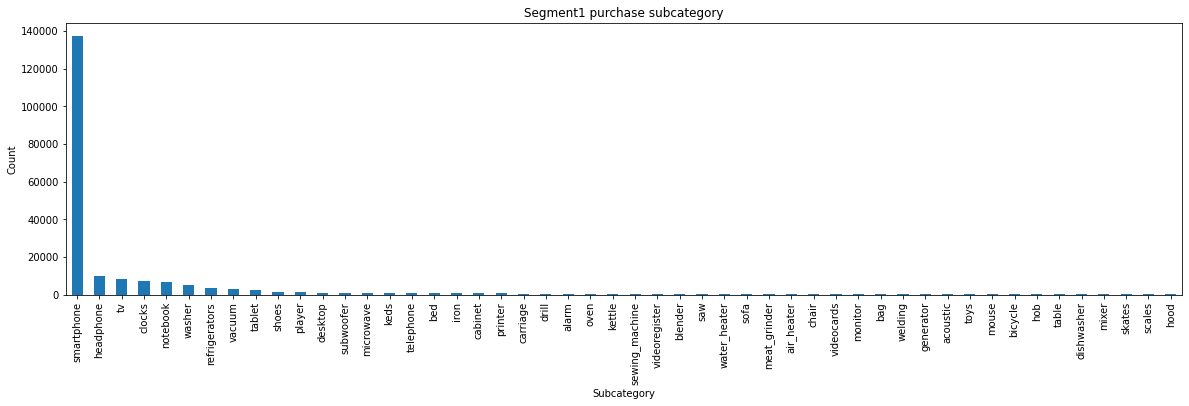

In [ ]:
# segment1 고객이 구매한 제품의 상위50개 소분류
seg1_purchase['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment1 purchase subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

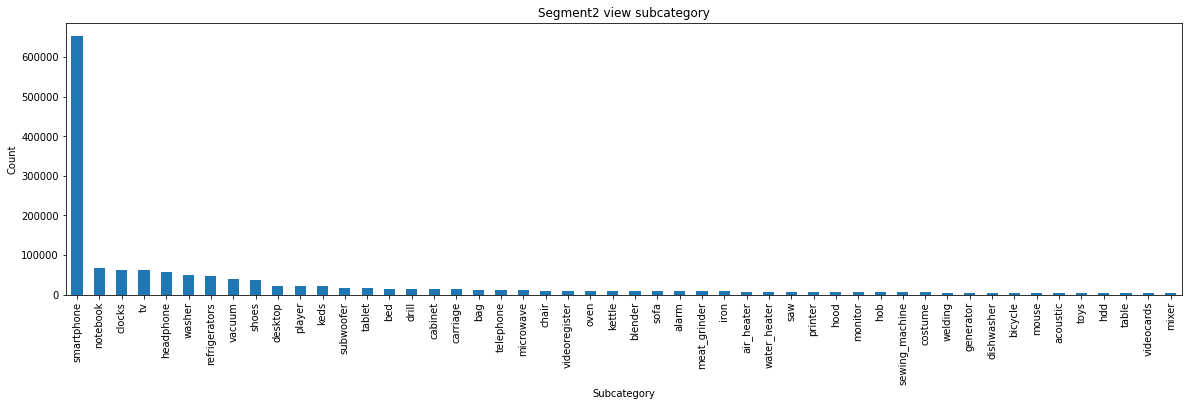

In [ ]:
# segment2 고객이 조회한 제품의 상위50개 소분류
seg2_view['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment2 view subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

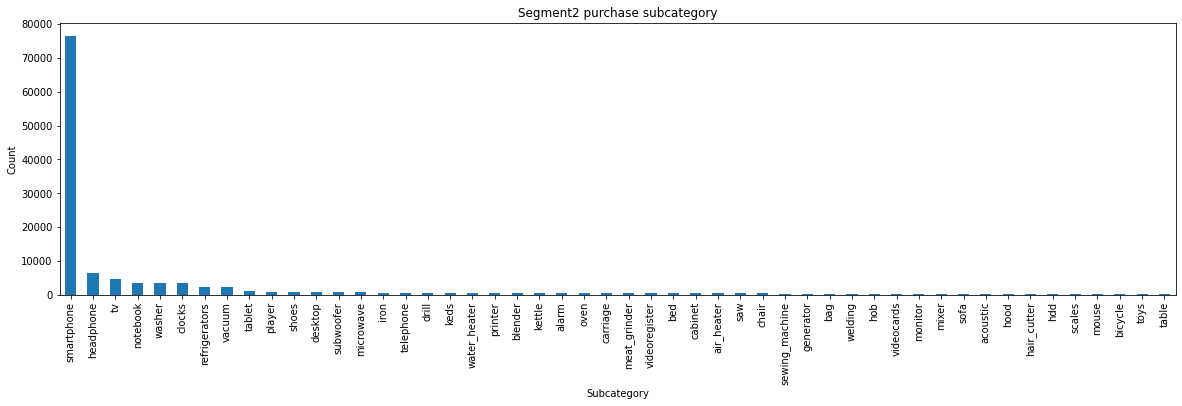

In [ ]:
# segment2 고객이 구매한 제품의 상위50개 소분류
seg2_purchase['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment2 purchase subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

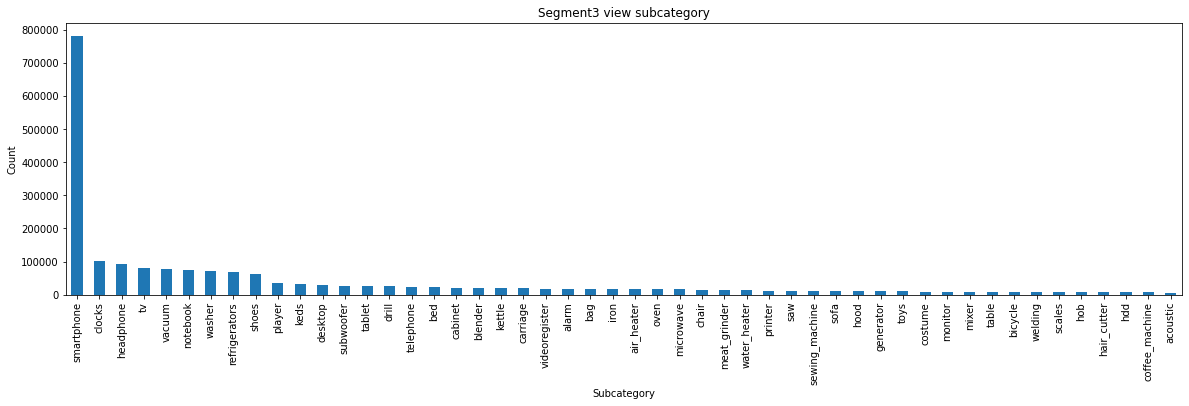

In [ ]:
# segment4 고객이 조회한 제품의 상위50개 소분류
seg4_view['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment3 view subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

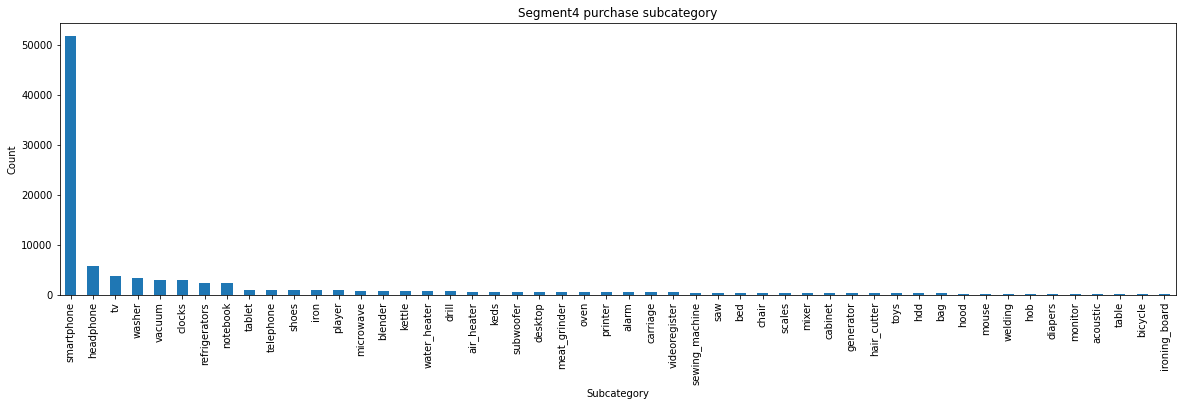

In [ ]:
# segment4 고객이 구매한 제품의 상위50개 소분류
seg4_purchase['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment4 purchase subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

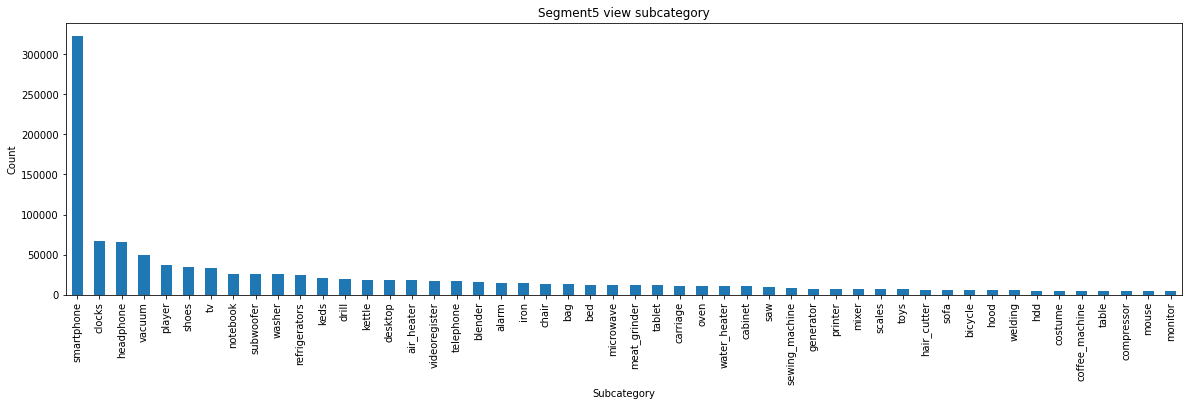

In [ ]:
# segment5 고객이 조회한 제품의 상위50개 소분류
seg5_view['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment5 view subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

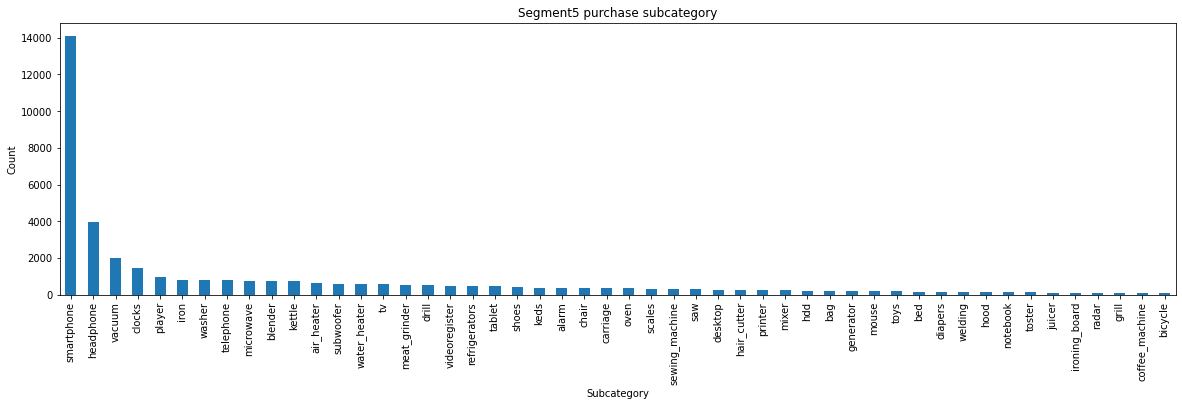

In [ ]:
# segment5 고객이 구매한 제품의 상위50개 소분류
seg5_purchase['subcategory'].value_counts().head(50).plot.bar(figsize=(20,5))
plt.title('Segment5 purchase subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.show();

- segment1 view : 스마트폰 → 노트북 → 티비 → 시계 → 헤드폰
- segment1 purchase : 스마트폰 → 헤드폰 → 티비 → 시계 → 노트북
---
- segment2 view : 스마트폰 → 노트북 → 시계 → 티비 → 헤드폰
- segment2 purchase : 스마트폰 → 헤드폰 → 티비 → 노트북 → 워셔(washer)
---
- segment4 view : 스마트폰 → 시계 → 헤드폰 → 티비 → 청소기
- segment4 purchase : 스마트폰 → 헤드폰 → 티비 → washer → 청소기
---
- segment5 view : 스마트폰 → 시계 → 헤드폰 → 청소기 → 게임기(player)
- segment5 purchase : 스마트폰 → 헤드폰 → 청소기 → 시계 → 게임기

In [ ]:
# 각 고객군이 조회한 제품 가격의 평균
seg1view_mean = seg1_view['price'].mean()
seg2view_mean = seg2_view['price'].mean()
seg4view_mean = seg4_view['price'].mean()
seg5view_mean = seg5_view['price'].mean()

In [ ]:
# 각 고객군이 구매한 제품 가격의 평균
seg1purchase_mean = seg1_purchase['price'].mean()
seg2purchase_mean = seg2_purchase['price'].mean()
seg4purchase_mean = seg4_purchase['price'].mean()
seg5purchase_mean = seg5_purchase['price'].mean()

In [ ]:
# 각 고객군이 조회한 제품 가격의 중앙값
seg1view_med = seg1_view['price'].median()
seg2view_med = seg2_view['price'].median()
seg4view_med = seg4_view['price'].median()
seg5view_med = seg5_view['price'].median()

In [ ]:
# 각 고객군이 구매한 제품 가격의 중앙값
seg1purchase_med = seg1_purchase['price'].median()
seg2purchase_med = seg2_purchase['price'].median()
seg4purchase_med = seg4_purchase['price'].median()
seg5purchase_med = seg5_purchase['price'].median()

In [26]:
data = [['충성고객',seg1view_mean, seg1purchase_mean, seg1view_med, seg1purchase_med], 
        ['잠재 충성고객 1', seg2view_mean, seg2purchase_mean, seg2view_med, seg2purchase_med],
        ['잠재 충성고객 2', seg4view_mean, seg4purchase_mean, seg4view_med, seg4purchase_med],
        ['변심고객', seg3view_mean, seg3purchase_mean, seg3view_med, seg3purchase_med],
        ['체리피커', seg5view_mean, seg5purchase_mean, seg5view_med, seg5purchase_med]]

In [27]:
segment = pd.DataFrame(data, columns=['segment','view_mean','purchase_mean','view_med','purchase_med'])

In [28]:
segment

,segment,view_mean,purchase_mean,view_med,purchase_med
0,충성고객,358.447005,406.662396,216.21,250.86
1,잠재 충성고객 1,315.897841,354.621592,177.10,204.12
2,잠재 충성고객 2,240.472325,230.488880,137.69,153.84
3,변심고객,258.686577,227.057716,142.86,135.01
4,체리피커,178.133936,88.117254,89.84,70.53


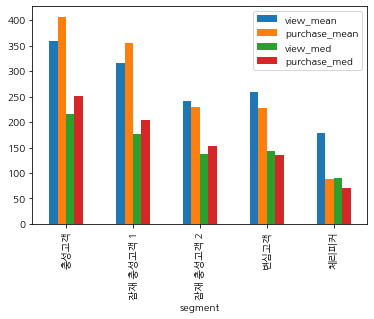

In [29]:
segment.plot.bar(x='segment', y=['view_mean','purchase_mean','view_med','purchase_med'])
plt.show();

### baseline 데이터셋

In [ ]:
# memory-out 문제를 해결하기 위해 전처리된 데이터 불러오기
recommend = pd.read_csv("/content/drive/MyDrive/df.csv")

In [ ]:
recommend = recommend.drop(columns = 'Unnamed: 0')

In [ ]:
# 카테고리 결측치 제거
non_category = recommend[recommend['category_code'].isnull()].index
recommend.drop(non_category, inplace=True)

In [ ]:
# 구매한 데이터를 통한 추천시스템 구현하기 위해 purchase 데이터만 분리
recommend = recommend.loc[recommend['event_type'] == 'purchase']

In [ ]:
recommend.shape

(569424, 11)

### computers baseline
- 제품간 추천

In [ ]:
com_base = recommend.loc[(recommend['main_category'] == 'computers')]

In [ ]:
com_base = com_base.reset_index(drop=True)

In [ ]:
com_base.drop(columns=['event_time', 'product_id','category_id','user_id','main_category','subcategory'], inplace=True)

In [ ]:
com_base.head()

,event_type,category_code,brand,price,user_session
0,purchase,computers.notebook,hp,320.35,104dc3e4-d6ff-4f00-9031-c0468e75ed4c
1,purchase,computers.peripherals.printer,epson,116.73,63de1120-9d48-45d0-b024-500d1b95d71f
2,purchase,computers.components.hdd,kingston,66.67,629a0485-36c9-4a80-9f02-4a96382c3059
3,purchase,computers.notebook,asus,879.96,4eb54277-2072-4b17-a275-dced7c3ae7ee
4,purchase,computers.notebook,NaN,431.67,76e5233a-000b-4aac-890a-f3a7c0e4c702


In [ ]:
tfidf = TfidfVectorizer()

# Fit 후 dtm을 만듭니다.(문서, 단어마다 tf-idf 값을 계산합니다)
dtm_com = tfidf.fit_transform(com_base['category_code'])

dtm_com = pd.DataFrame(dtm_com.todense(), columns=tfidf.get_feature_names())
dtm_com

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,camera,components,computers,cooler,cpu,desktop,ebooks,hdd,keyboard,memory,monitor,motherboard,mouse,notebook,peripherals,power_supply,printer,videocards
0,0.0,0.000000,0.534712,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.845034,0.000000,0.0,0.000000,0.0000
1,0.0,0.000000,0.224798,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.600976,0.0,0.767003,0.0000
2,0.0,0.571631,0.186198,0.0,0.0,0.000000,0.0,0.799105,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0000
3,0.0,0.000000,0.534712,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.845034,0.000000,0.0,0.000000,0.0000
4,0.0,0.000000,0.534712,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.845034,0.000000,0.0,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27850,0.0,0.000000,0.534712,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.845034,0.000000,0.0,0.000000,0.0000
27851,0.0,0.553899,0.180423,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.8128
27852,0.0,0.553899,0.180423,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.8128
27853,0.0,0.000000,0.534712,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.845034,0.000000,0.0,0.000000,0.0000


In [ ]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(dtm_com.values)

NearestNeighbors()

In [ ]:
nn.kneighbors([dtm_com.iloc[2]])

(array([[0., 0., 0., 0., 0.]]), array([[22951, 19062, 23188,  1566,  5532]]))

In [ ]:
com_base.loc[com_base['user_session'] == '629a0485-36c9-4a80-9f02-4a96382c3059']

,event_type,category_code,brand,price,user_session
2,purchase,computers.components.hdd,kingston,66.67,629a0485-36c9-4a80-9f02-4a96382c3059


In [ ]:
com_base.iloc[[22951]]

,event_type,category_code,brand,price,user_session
22951,purchase,computers.components.hdd,samsung,204.87,30399143-8e68-43de-9d40-1ac965814690


In [ ]:
com_base.iloc[[19062]]

,event_type,category_code,brand,price,user_session
19062,purchase,computers.components.hdd,kingston,62.01,79fb2320-d81f-4c39-aa5e-6eb3eb87b7e8


In [ ]:
com_base.iloc[[23188]]

,event_type,category_code,brand,price,user_session
23188,purchase,computers.components.hdd,kingston,431.05,6f31018c-e5f2-400e-845a-202f32c522c8


In [ ]:
com_base.iloc[[1566]]

,event_type,category_code,brand,price,user_session
1566,purchase,computers.components.hdd,toshiba,250.66,c426776b-36db-40be-8f68-9767fca31cb7


In [ ]:
com_base.iloc[[5532]]

,event_type,category_code,brand,price,user_session
5532,purchase,computers.components.hdd,toshiba,44.49,dec9a27a-14bd-4c80-9183-9388a2dc5866


### computers baseline
- 유저간 추천

In [ ]:
tfidf = TfidfVectorizer(max_features = 100)

# Fit 후 dtm을 만듭니다.(문서, 단어마다 tf-idf 값을 계산합니다)
dtm_com_session = tfidf.fit_transform(com_base['user_session'])

dtm_com_session = pd.DataFrame(dtm_com_session.todense(), columns=tfidf.get_feature_names())
dtm_com_session

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,404c,4059,405d,40cf,40d7,40f1,4179,41b7,41d6,41ee,...,4fc9,4fcc,525b,91aaff3b5487,a0af,b439,b7396a89,bfe4,d095d5410e6b,eccfccbe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(dtm_com_session.values)

NearestNeighbors()

In [ ]:
nn.kneighbors([dtm_com_session.iloc[2]])

(array([[0., 0., 0., 0., 0.]]), array([[18296, 18295, 18298, 18300, 18297]]))

In [ ]:
com_base.loc[com_base['user_session'] == '629a0485-36c9-4a80-9f02-4a96382c3059']

,event_type,category_code,brand,price,user_session
2,purchase,computers.components.hdd,kingston,66.67,629a0485-36c9-4a80-9f02-4a96382c3059


In [ ]:
com_base.iloc[[18296]]

,event_type,category_code,brand,price,user_session
18296,purchase,computers.desktop,lenovo,385.85,7b2d41c4-1357-4c43-bca2-510c5b37289c


In [ ]:
com_base.iloc[[18296]]

,event_type,category_code,brand,price,user_session
18296,purchase,computers.desktop,lenovo,385.85,7b2d41c4-1357-4c43-bca2-510c5b37289c


In [ ]:
com_base.iloc[[18298]]

,event_type,category_code,brand,price,user_session
18298,purchase,computers.notebook,acer,1106.82,afc38891-5452-4c47-9c66-cea345279b83


In [ ]:
com_base.iloc[[18300]]

,event_type,category_code,brand,price,user_session
18300,purchase,computers.notebook,hp,249.43,6c35b7d7-a20d-4d2f-878f-798aa7e65fdc


In [ ]:
com_base.iloc[[18297]]

,event_type,category_code,brand,price,user_session
18297,purchase,computers.peripherals.mouse,logitech,14.13,39fce100-afef-4bcc-8911-e85dab6f5fd4


### appliances baseline
- 제품간 추천

In [ ]:
appli_base = recommend.loc[(recommend['main_category'] == 'appliances')]

In [ ]:
appli_base.drop(columns=['event_time', 'product_id','category_id','main_category','subcategory'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
appli_base.reset_index(drop=True, inplace=True)

In [ ]:
appli_base.head()

,event_type,category_code,brand,price,user_id,user_session
0,purchase,appliances.environment.air_heater,oasis,28.03,548691404,b67cdbcb-b073-4271-b365-803c6fce53b0
1,purchase,appliances.kitchen.meat_grinder,philips,120.95,553819262,94b897fc-80c6-492c-a456-707398c7cc8e
2,purchase,appliances.kitchen.blender,panasonic,51.46,527681026,feb31d4f-ceb5-4710-8a8e-391abeaca106
3,purchase,appliances.kitchen.washer,lg,308.65,513419646,5e227e58-6117-419c-b45d-ac54be44716d
4,purchase,appliances.environment.vacuum,lg,189.26,512584306,510447fa-8dee-4027-a80a-a17dab9260af


In [ ]:
tfidf = TfidfVectorizer()

# Fit 후 dtm을 만듭니다.(문서, 단어마다 tf-idf 값을 계산합니다)
dtm_appli = tfidf.fit_transform(appli_base['category_code'])

dtm_appli = pd.DataFrame(dtm_appli.todense(), columns=tfidf.get_feature_names())
dtm_appli

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,air_conditioner,air_heater,appliances,blender,coffee_grinder,coffee_machine,dishwasher,environment,fan,grill,...,oven,personal,refrigerators,scales,sewing_machine,steam_cooker,toster,vacuum,washer,water_heater
0,0.0,0.859497,0.195004,0.000000,0.0,0.0,0.0,0.472480,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.000000,0.209067,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.000000,0.219490,0.922724,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,0.0,0.000000,0.324215,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.822077,0.0
4,0.0,0.000000,0.260655,0.000000,0.0,0.0,0.0,0.631546,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.730211,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74991,0.0,0.000000,0.228602,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
74992,0.0,0.000000,0.210041,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.977692,0.0,0.0,0.000000,0.000000,0.0
74993,0.0,0.000000,0.324215,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.822077,0.0
74994,0.0,0.000000,0.294971,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.85537,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [ ]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(dtm_appli.values)

NearestNeighbors()

In [ ]:
nn.kneighbors([dtm_appli.iloc[2270]])

(array([[0., 0., 0., 0., 0.]]), array([[26988, 57937, 71675, 70806, 26987]]))

In [ ]:
appli_base.loc[appli_base['user_session'] == '4ff62316-20c5-4edf-a9c5-0e9bca818a18']

,event_type,category_code,brand,price,user_id,user_session
2270,purchase,appliances.kitchen.hood,hansa,102.68,547720935,4ff62316-20c5-4edf-a9c5-0e9bca818a18


In [ ]:
appli_base.iloc[[26988]]

,event_type,category_code,brand,price,user_id,user_session
26988,purchase,appliances.kitchen.hood,dauscher,95.21,515600682,b8924bc0-7245-40a9-a3c2-21f479158c1e


In [ ]:
appli_base.iloc[[57937]]

,event_type,category_code,brand,price,user_id,user_session
57937,purchase,appliances.kitchen.hood,gefest,57.66,517489779,940fb671-f7ed-45e7-b10e-10f003b4e658


In [ ]:
appli_base.iloc[[71675]]

,event_type,category_code,brand,price,user_id,user_session
71675,purchase,appliances.kitchen.hood,bosch,102.94,538413875,550c58de-1c2f-49f9-83a0-153a43130ffa


In [ ]:
appli_base.iloc[[70806]]

,event_type,category_code,brand,price,user_id,user_session
70806,purchase,appliances.kitchen.hood,turboair,40.85,558522747,11e1266b-facd-4788-b6eb-6e479da089cf


In [ ]:
appli_base.iloc[[26987]]

,event_type,category_code,brand,price,user_id,user_session
26987,purchase,appliances.kitchen.hood,dauscher,90.07,531283578,9c2c86f9-b2ad-4f7f-bd8a-0fc57138ae06


### appliances baseline
- 유저간 추천

In [ ]:
tfidf = TfidfVectorizer(max_features = 100)

# Fit 후 dtm을 만듭니다.(문서, 단어마다 tf-idf 값을 계산합니다)
dtm_appli_session = tfidf.fit_transform(appli_base['user_session'])

In [ ]:
dtm_appli_session = pd.DataFrame(dtm_appli_session.todense(), columns=tfidf.get_feature_names())
dtm_appli_session

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,4016,4048,4067,40b3,40f4,40fb,40fd,4135,4147,4165,...,4e7e,4eb7,4eba,4efb,4f3a,4f57,4f6c,4f9b,4fa2,4ff9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(dtm_appli_session.values)

NearestNeighbors()

In [ ]:
nn.kneighbors([dtm_appli_session.iloc[2270]])

(array([[0., 0., 0., 0., 0.]]), array([[49452, 49453, 49451, 49449, 49454]]))

In [ ]:
appli_base.loc[appli_base['user_session'] == '4ff62316-20c5-4edf-a9c5-0e9bca818a18']

,event_type,category_code,brand,price,user_id,user_session
2270,purchase,appliances.kitchen.hood,hansa,102.68,547720935,4ff62316-20c5-4edf-a9c5-0e9bca818a18


In [ ]:
appli_base.iloc[[49452]]

,event_type,category_code,brand,price,user_id,user_session
49452,purchase,appliances.kitchen.washer,samsung,334.6,518644283,c4f825de-0d53-4c67-bc00-d7476f509041


In [ ]:
appli_base.iloc[[49453]]

,event_type,category_code,brand,price,user_id,user_session
49453,purchase,appliances.kitchen.microwave,arg,56.6,523999245,7edca5cb-0b3a-4761-ae71-cbc04ca4e5a1


In [ ]:
appli_base.iloc[[49451]]

,event_type,category_code,brand,price,user_id,user_session
49451,purchase,appliances.environment.vacuum,philips,101.93,516252748,9f8e1994-af56-48df-b2b1-287436db0d73


In [ ]:
appli_base.iloc[[49449]]

,event_type,category_code,brand,price,user_id,user_session
49449,purchase,appliances.iron,vitek,28.06,543773886,df71ca64-4c2d-49b3-8f4d-44ea53e6a243


In [ ]:
appli_base.iloc[[49454]]

,event_type,category_code,brand,price,user_id,user_session
49454,purchase,appliances.kitchen.washer,samsung,593.79,521343725,41bd1ccb-3026-4400-81a0-2ee814354f51


### electronics baseline
- 제품간 추천

In [ ]:
elec_base = recommend.loc[(recommend['main_category'] == 'electronics')]

In [ ]:
elec_base.drop(columns=['event_time', 'event_type','product_id','category_id','main_category','subcategory'], inplace=True)
elec_base.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
elec_base.head()

,category_code,brand,price,user_id,user_session
0,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
1,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
2,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553
3,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
4,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238


In [ ]:
tfidf = TfidfVectorizer()

# Fit 후 dtm을 만듭니다.(문서, 단어마다 tf-idf 값을 계산합니다)
dtm_elec = tfidf.fit_transform(elec_base['category_code'])

In [ ]:
dtm_elec = pd.DataFrame(dtm_elec.todense(), columns=tfidf.get_feature_names())
dtm_elec

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,acoustic,audio,camera,clocks,electronics,headphone,microphone,music_tools,photo,piano,projector,smartphone,subwoofer,tablet,telephone,tv,video
0,0.0,0.000000,0.0,0.0,0.632581,0.000000,0.0,0.0,0.0,0.0,0.0,0.774494,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.632581,0.000000,0.0,0.0,0.0,0.0,0.0,0.774494,0.0,0.0,0.0,0.0,0.0
2,0.0,0.678288,0.0,0.0,0.195174,0.708401,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.678288,0.0,0.0,0.195174,0.708401,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.632581,0.000000,0.0,0.0,0.0,0.0,0.0,0.774494,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423023,0.0,0.000000,0.0,0.0,0.632581,0.000000,0.0,0.0,0.0,0.0,0.0,0.774494,0.0,0.0,0.0,0.0,0.0
423024,0.0,0.000000,0.0,0.0,0.632581,0.000000,0.0,0.0,0.0,0.0,0.0,0.774494,0.0,0.0,0.0,0.0,0.0
423025,0.0,0.000000,0.0,0.0,0.632581,0.000000,0.0,0.0,0.0,0.0,0.0,0.774494,0.0,0.0,0.0,0.0,0.0
423026,0.0,0.000000,0.0,0.0,0.632581,0.000000,0.0,0.0,0.0,0.0,0.0,0.774494,0.0,0.0,0.0,0.0,0.0


In [ ]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(dtm_elec.values)

NearestNeighbors()

In [ ]:
nn.kneighbors([dtm_elec.iloc[10]])

(array([[0., 0., 0., 0., 0.]]),
 array([[360163,  21670, 226526, 157434, 260435]]))

In [ ]:
elec_base.loc[elec_base['user_session'] == '0c990471-9407-4292-a6df-0cbc2f722a40']

,category_code,brand,price,user_id,user_session
10,electronics.audio.headphone,xiaomi,23.13,540557704,0c990471-9407-4292-a6df-0cbc2f722a40


In [ ]:
elec_base.iloc[[360163]]

,category_code,brand,price,user_id,user_session
360163,electronics.audio.headphone,xiaomi,43.5,513079004,beaacf93-9660-4eab-be29-456af011ef93


In [ ]:
elec_base.iloc[[21670]]

,category_code,brand,price,user_id,user_session
21670,electronics.audio.headphone,samsung,45.42,512790285,cf4695c3-b478-4044-bde5-54c42b67d53b


In [ ]:
elec_base.iloc[[226526]]

,category_code,brand,price,user_id,user_session
226526,electronics.audio.headphone,apple,160.62,516057735,c2e90167-31c8-4c24-8fc7-49d0a449cb5b


In [ ]:
elec_base.iloc[[157434]]

,category_code,brand,price,user_id,user_session
157434,electronics.audio.headphone,huawei,38.97,519018305,4923005e-9c55-4789-ae2a-5d911a3bfcaa


In [ ]:
elec_base.iloc[[260435]]

,category_code,brand,price,user_id,user_session
260435,electronics.audio.headphone,apple,160.62,516228144,a7d973cd-2a10-484f-9d32-73c7c2918635


### electronics baseline
- 유저간 추천

In [ ]:
tfidf = TfidfVectorizer(max_features = 100)

# Fit 후 dtm을 만듭니다.(문서, 단어마다 tf-idf 값을 계산합니다)
dtm_elec_session = tfidf.fit_transform(elec_base['user_session'])

In [ ]:
dtm_elec_session = pd.DataFrame(dtm_elec_session.todense(), columns=tfidf.get_feature_names())
dtm_elec_session

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,4005,4008,4079,40fc,4103,4163,416d,419f,41cf,4244,...,4e7d,4e8c,4eb3,4ec2,4ee0,4efe,4f8d,4f90,4fa6,4fd4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(dtm_elec_session.values)

NearestNeighbors()

In [ ]:
nn.kneighbors([dtm_elec_session.iloc[10]])

(array([[0., 0., 0., 0., 0.]]),
 array([[279575, 279574, 279577, 279578, 279576]]))

In [ ]:
elec_base.loc[(elec_base['user_session'] == '0c990471-9407-4292-a6df-0cbc2f722a40')]

,category_code,brand,price,user_id,user_session
10,electronics.audio.headphone,xiaomi,23.13,540557704,0c990471-9407-4292-a6df-0cbc2f722a40


In [ ]:
elec_base.iloc[[279575]]

,category_code,brand,price,user_id,user_session
279575,electronics.smartphone,oppo,257.38,560370787,1d5b25ec-2182-412c-8d4d-d66d27df8fbd


In [ ]:
elec_base.iloc[[279574]]

,category_code,brand,price,user_id,user_session
279574,electronics.smartphone,samsung,217.04,537726404,9d2fe03b-673d-44b6-b1ff-ac479c2cef99


In [ ]:
elec_base.iloc[[279577]]

,category_code,brand,price,user_id,user_session
279577,electronics.smartphone,apple,533.35,562337268,fefa6e1b-6866-4fff-983d-5759a18ce048


In [ ]:
elec_base.iloc[[279578]]

,category_code,brand,price,user_id,user_session
279578,electronics.audio.headphone,apple,190.34,520579186,57173626-c824-411b-89b5-4609ebcef3b1


In [ ]:
elec_base.iloc[[279576]]

,category_code,brand,price,user_id,user_session
279576,electronics.smartphone,samsung,370.6,562458518,15773585-45c4-4a44-ac0f-148db3a1e0fb
